In [ ]:
!git clone https://github.com/mauriciocruzriveros/BasededatosFlavonoides

In [ ]:
cd BasededatosFlavonoides/

In [ ]:
!pip install rdkit

In [1]:
import pandas as pd
from rdkit import Chem
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
import numpy as np
import rdkit
import re

# CSV Flavonoides
_________________________________________________________________________________________________________________________________________________________

In [2]:
df = pd.read_csv("flavonoids_data_final.csv")
df.head()

,ChEBI ID,ChEBI Name,SMILES,PubChem SID,deltag
0,177972,"3,4,5-trihydroxy-6-{[5,6,7-trihydroxy-2-(4-hyd...",O1C(OC2=C(OC3=C(C2=O)C(O)=C(O)C(O)=C3)C4=CC(OC...,SID: 85377015\nCID: 131835070,-9.4
1,191634,Neoliquiritin 2''-apioside,O(C1C(O)C(O)C(OC1OC2=CC=3OC(CC(=O)C3C=C2)C4=CC...,SID: 85390422\nCID: 131752849,-9.9
2,186794,Haploside F,O(C1[C@@H](O)[C@H](O)C(O[C@H]1OC2=C(O)C=3OC(=C...,SID: 85385648\nCID: 44260005,-10.3
3,197154,Sagittatoside A,O([C@@H]1[C@H](O)[C@@H](O)[C@@H](O[C@H]1OC2=C(...,SID: 85395895\nCID: 13916054,-10.6
4,188752,Diosmetin 7-O-beta-D-glucopyranoside,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC=2...,SID: 85387578\nCID: 11016019,-9.0


# Preparación del DataSet
_________________________________________________________________________________________________________________________________________________________

Separamos las columas dentro de PubChem SID

In [3]:
def extraer_sid_cid(row):
    if pd.isna(row):
        return None, None
    sid_match = re.search(r'SID:\s*(\d+)', str(row))
    cid_match = re.search(r'CID:\s*(\d+)', str(row))
    sid = sid_match.group(1) if sid_match else None
    cid = cid_match.group(1) if cid_match else None
    return sid, cid

# Aplicar la función a la columna que contiene información de SID y CID
df['SID'], df['CID'] = zip(*df['PubChem SID'].apply(extraer_sid_cid))
df[["PubChem SID",'SID', 'CID']].sample(n=4)

,PubChem SID,SID,CID
1319,CID: 44259845\nSID: 85368830,85368830,44259845
49,SID: 85391699\nCID: 44258156,85391699,44258156
1360,CID: 44260037\nSID: 85379439,85379439,44260037
487,CID: 44260043\nSID: 85379438,85379438,44260043


In [4]:
#Eliminar columna "PubChem SID" ya que ya fué separada
df = df.drop("PubChem SID", axis=1)
df.head()

,ChEBI ID,ChEBI Name,SMILES,deltag,SID,CID
0,177972,"3,4,5-trihydroxy-6-{[5,6,7-trihydroxy-2-(4-hyd...",O1C(OC2=C(OC3=C(C2=O)C(O)=C(O)C(O)=C3)C4=CC(OC...,-9.4,85377015,131835070
1,191634,Neoliquiritin 2''-apioside,O(C1C(O)C(O)C(OC1OC2=CC=3OC(CC(=O)C3C=C2)C4=CC...,-9.9,85390422,131752849
2,186794,Haploside F,O(C1[C@@H](O)[C@H](O)C(O[C@H]1OC2=C(O)C=3OC(=C...,-10.3,85385648,44260005
3,197154,Sagittatoside A,O([C@@H]1[C@H](O)[C@@H](O)[C@@H](O[C@H]1OC2=C(...,-10.6,85395895,13916054
4,188752,Diosmetin 7-O-beta-D-glucopyranoside,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC=2...,-9.0,85387578,11016019


### Verificar si RDkit reconoce nuestros SMILES correctamente

In [5]:
smiles_column = df["SMILES"]
# Contador N° de Moleculas Reconocidas
num_molecules_recognized = 0
# Verificar cada SMILES con RdKit
for smiles in smiles_column:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        num_molecules_recognized += 1
    else:
        print(f"SMILES: {smiles} - No se pudo reconocer")

# Imprimir el número total de moléculas reconocidas correctamente
print(f"Total de moléculas reconocidas correctamente: {num_molecules_recognized}")

Total de moléculas reconocidas correctamente: 1531


# Añadimos columnas de interes a nuestro dataframe
Los SMILES del dataset nos permiten trabajar con RDKIT, de esta manera podemos analizar caracteristicas de nuestras moleculas en el set, como contar el numero de carbonos, o buscar alguna estructura como anillos aromáticos
____________________________________________________________________________________________________
En este caso vamos a contar el numero de carbonos en un set de moleculas de Test para verificar la función de busqueda:
____________________________________________________________________________________________________

### Test contar Carbonos: 

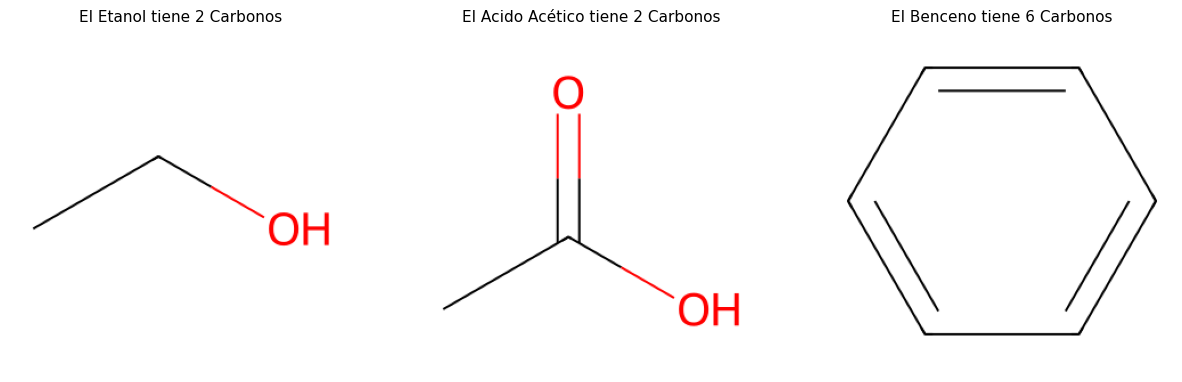

In [6]:
# Función para calcular el N° de Carbonos en nuestro DataFrame de Flavonoides:
def calcular_num_carbonos(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_carbonos = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'C'])
        return num_carbonos
    else:
        return None       
#Función para conseguir imagen de moleculas
def plot_molecula(smile):
    mol = Chem.MolFromSmiles(smile)
    img = Draw.MolToImage(mol)
    return img
    
#TEST = Probamos con moleculas conocidas para obtener resultados esperados
# Moleculas conocidas para N° CARBONOS
EtanolSmile = "CCO"             # Etanol
AcidoAceticoSmile = "CC(=O)O"  # Ácido acético
BencenoSmile = "C1=CC=CC=C1"  # Benceno
#Usar Función para moleculas
Etanol = calcular_num_carbonos(EtanolSmile)
AcidoAcetico = calcular_num_carbonos(AcidoAceticoSmile)
Benceno = calcular_num_carbonos(BencenoSmile)
#Imagenes de  moleculas
img_Etanol=plot_molecula(EtanolSmile)
img_AcidoAcetico=plot_molecula(AcidoAceticoSmile)
img_Benceno=plot_molecula(BencenoSmile)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Ajusta el tamaño de la figura
# Subplot 1 = Calcular enlaces dobles Flavanona
axs[0].imshow(img_Etanol)
axs[0].set_title(f"El Etanol tiene {Etanol} Carbonos",fontsize=11)
axs[0].axis('off')
# Subplot 2 = Calcular enlaces dobles Flavanol
axs[1].imshow(img_AcidoAcetico)
axs[1].axis('off')
axs[1].set_title(f"El Acido Acético tiene {AcidoAcetico} Carbonos",fontsize=11)
#Subplot 3 = Calcular enlaces dobles Nitrisona
axs[2].imshow(img_Benceno)
axs[2].axis('off')
axs[2].set_title(f"El Benceno tiene {Benceno} Carbonos",fontsize=11)
# Mostrar
plt.show()

#### Una vez verificamos la función la aplicamos a nuestro dataframe y agrupamos a nuestras moleculas bajo esta característica:

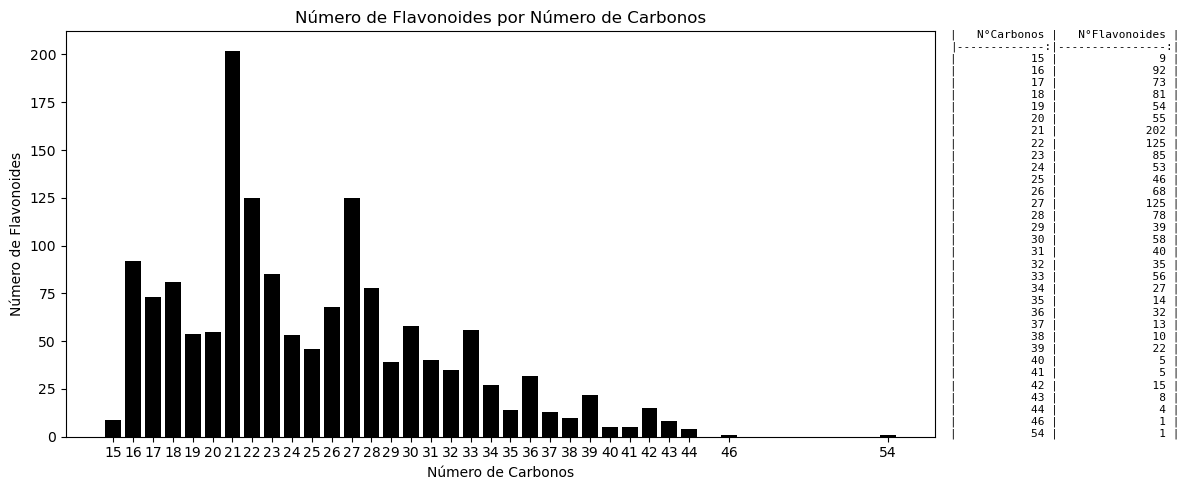

,ChEBI ID,ChEBI Name,SMILES,deltag,SID,CID,N°Carbonos
0,177972,"3,4,5-trihydroxy-6-{[5,6,7-trihydroxy-2-(4-hyd...",O1C(OC2=C(OC3=C(C2=O)C(O)=C(O)C(O)=C3)C4=CC(OC...,-9.4,85377015,131835070,22
1,191634,Neoliquiritin 2''-apioside,O(C1C(O)C(O)C(OC1OC2=CC=3OC(CC(=O)C3C=C2)C4=CC...,-9.9,85390422,131752849,26
2,186794,Haploside F,O(C1[C@@H](O)[C@H](O)C(O[C@H]1OC2=C(O)C=3OC(=C...,-10.3,85385648,44260005,28
3,197154,Sagittatoside A,O([C@@H]1[C@H](O)[C@@H](O)[C@@H](O[C@H]1OC2=C(...,-10.6,85395895,13916054,33
4,188752,Diosmetin 7-O-beta-D-glucopyranoside,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC=2...,-9.0,85387578,11016019,22


In [7]:
df['N°Carbonos'] = df['SMILES'].apply(calcular_num_carbonos)
# Agrupar por el número de carbonos y contar el número de Flavonoides en cada grupo
grupos_por_carbonos = df.groupby('N°Carbonos').size()
# Convertir la Serie en un DataFrame
df_resultado_carbonos = grupos_por_carbonos.reset_index()
df_resultado_carbonos.columns = ["N°Carbonos", "N°Flavonoides"]
# Markdown
df_resultado_md = df_resultado_carbonos.to_markdown(index=False)

# Plot
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[100, 1])  # Ancho relativo de los subplots
# Subplot 1 = Grafico Carbono
ax1 = fig.add_subplot(gs[0]) #Añadir subplot ax1 a primera cuadricula del plot
ax1.bar(df_resultado_carbonos['N°Carbonos'], df_resultado_carbonos['N°Flavonoides'], color='black', width=0.8) #Columnas del Df
ax1.set_xlabel('Número de Carbonos')
ax1.set_ylabel('Número de Flavonoides')
ax1.set_title('Número de Flavonoides por Número de Carbonos')
ax1.set_xticks(df_resultado_carbonos['N°Carbonos']) 
# Sub plot 2 = Markdown
ax2 = fig.add_subplot(gs[1])
ax2.text(0, 0.5, df_resultado_md, ha='left', va='center', fontsize=8, color='black', fontfamily='monospace')
ax2.axis('off')  # Desactivar ejes 
#Mostrar Plot 
plt.tight_layout()
plt.show()
#Df
df.head()

#### Hacemos lo mismo con los Oxigenos:

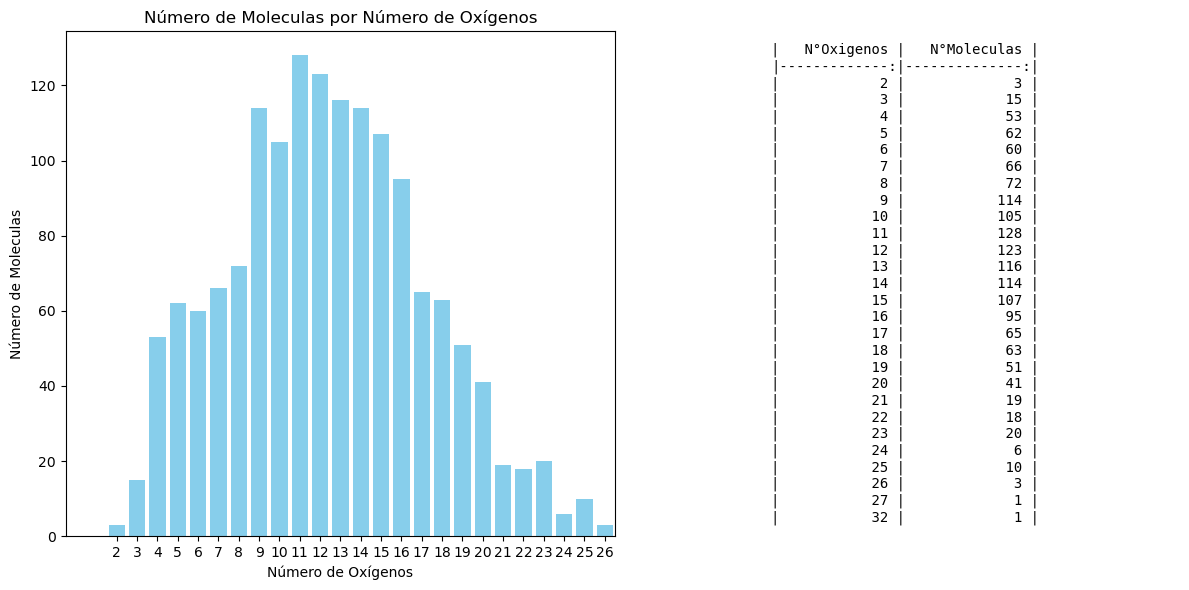

In [8]:
def calcular_num_oxigenos(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_oxigenos = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'O'])
        return num_oxigenos
    else:
        return None
        
# Aplicar la función a la columna SMILES para calcular el número de oxígenos
df['N°Oxigenos'] = df['SMILES'].apply(calcular_num_oxigenos)
# Agrupar por el número de oxígenos y contar el número de Flavonoides en cada grupo
grupos_por_oxigenos = df.groupby('N°Oxigenos').size()
# Convertir la Serie en un DataFrame
df_resultado_oxigeno = grupos_por_oxigenos.reset_index()
df_resultado_oxigeno.columns = ["N°Oxigenos", "N°Moleculas"]
# Convertir el DataFrame a formato Markdown
df_resultado_md = df_resultado_oxigeno.to_markdown(index=False)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Subplot 1 = Gráfico
ax1.bar(df_resultado_oxigeno['N°Oxigenos'], df_resultado_oxigeno['N°Moleculas'], color='skyblue')
ax1.set_xlabel('Número de Oxígenos')
ax1.set_ylabel('Número de Moleculas')
ax1.set_title('Número de Moleculas por Número de Oxígenos')
ax1.set_xticks(df_resultado_oxigeno['N°Oxigenos'])
ax1.grid(False)  # Desactivar las cuadrículas en el gráfico
# Subplot 2 = Markdown
ax2.axis('off')  # Desactivar ejes en el segundo subplot
ax2.text(0.5, 0.5, df_resultado_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
# Agrandar el eje x en el gráfico de barras
ax1.set_xlim(-0.5, len(df_resultado_oxigeno) - 0.5)
#Mostrar 
plt.tight_layout()
plt.show()

#### Y ahora para buscar átomos menos probables:

In [9]:
def calcular_num_cobre(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_cobre = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'Cu'])
        return num_cobre
    else:
        return None
        
df['N°Cu'] = df['SMILES'].apply(calcular_num_cobre)
# Generar DataFrame agrupado por Cu "Groupby"
grupos_por_cobre = df.groupby('N°Cu').size().reset_index()
grupos_por_cobre.columns = ["N°Cu", "N° Flavonoides"]

# Imprimir resultados
print("Resultados:")
print(grupos_por_cobre)
print("\n___________________________")
print("Df")
print("___________________________")
# Imprimir la columna 'N°Cu' del df con su header
print(df['N°Cu'].to_frame())

Resultados:
   N°Cu  N° Flavonoides
0     0            1531

___________________________
Df
___________________________
      N°Cu
0        0
1        0
2        0
3        0
4        0
...    ...
1526     0
1527     0
1528     0
1529     0
1530     0

[1531 rows x 1 columns]


In [10]:
def calcular_num_fierro(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_fierro = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'Fe'])
        return num_fierro
    else:
        return None

# Aplicar la función a la columna SMILES 
df['N°Fe'] = df['SMILES'].apply(calcular_num_fierro)

# Generar DataFrame agrupado por Fe  "Groupby"
grupos_por_fierro = df.groupby('N°Fe').size().reset_index()
grupos_por_fierro.columns = ["N°Fe", "N°Flavonoides"]

# Imprimir resultados
print("Resultados:")
print(grupos_por_fierro)
print("___________________________")
print("Df")
print("___________________________")
# Imprimir la columna 'N°Fe' del df con su header
print(df['N°Fe'].to_frame().sample(n=10))

Resultados:
   N°Fe  N°Flavonoides
0     0           1531
___________________________
Df
___________________________
      N°Fe
734      0
615      0
708      0
1462     0
827      0
427      0
436      0
1480     0
1247     0
1165     0


In [11]:
def calcular_num_S(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_S = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'S'])
        return num_S
    else:
        return None

# Aplicar la función a la columna SMILES 
df['N°S'] = df['SMILES'].apply(calcular_num_S)
# Generar DataFrame agrupado por Fe  "Groupby"
grupos_por_S = df.groupby('N°S').size().reset_index()
grupos_por_S.columns = ["N°S", "N°Flavonoides"]

# Imprimir resultados
print("Resultados:")
print(grupos_por_S)
print("___________________________")
print("Df")
print("___________________________")
# Imprimir la columna 'N°S' del df con su header
print(df['N°S'].to_frame().sample(n=10))

Resultados:
   N°S  N°Flavonoides
0    0           1459
1    1             66
2    2              6
___________________________
Df
___________________________
      N°S
963     0
546     0
1127    0
1110    0
1050    0
1367    0
787     0
1108    0
486     0
257     0


In [12]:
def calcular_num_N(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_N = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'N'])
        return num_N
    else:
        return None

# Calcular el número de Cu en la columna SMILES
df['N°N'] = df['SMILES'].apply(calcular_num_N)

# Generar DataFrame agrupado por Cu "Groupby"
grupos_por_N = df.groupby('N°N').size().reset_index()
grupos_por_N.columns = ["N°N", "N° Flavonoides"]

# Imprimir resultados
print("Resultados:")
print(grupos_por_N)
print("___________________________")
print("Df")
print("___________________________")
# Imprimir la columna 'N°N' del df con su header
print(df['N°N'].to_frame().sample(n=10))

Resultados:
   N°N  N° Flavonoides
0    0            1518
1    1              12
2    3               1
___________________________
Df
___________________________
      N°N
1109    0
655     0
91      0
1414    0
1393    0
716     0
1367    0
1368    0
310     0
819     0


In [13]:
#Algunas columnas que generamos no nos entregan información util, será mejor borrarlas:
df = df.drop("N°Fe", axis=1)
df = df.drop("N°Cu", axis=1)
df.head()

,ChEBI ID,ChEBI Name,SMILES,deltag,SID,CID,N°Carbonos,N°Oxigenos,N°S,N°N
0,177972,"3,4,5-trihydroxy-6-{[5,6,7-trihydroxy-2-(4-hyd...",O1C(OC2=C(OC3=C(C2=O)C(O)=C(O)C(O)=C3)C4=CC(OC...,-9.4,85377015,131835070,22,14,0,0
1,191634,Neoliquiritin 2''-apioside,O(C1C(O)C(O)C(OC1OC2=CC=3OC(CC(=O)C3C=C2)C4=CC...,-9.9,85390422,131752849,26,13,0,0
2,186794,Haploside F,O(C1[C@@H](O)[C@H](O)C(O[C@H]1OC2=C(O)C=3OC(=C...,-10.3,85385648,44260005,28,17,0,0
3,197154,Sagittatoside A,O([C@@H]1[C@H](O)[C@@H](O)[C@@H](O[C@H]1OC2=C(...,-10.6,85395895,13916054,33,15,0,0
4,188752,Diosmetin 7-O-beta-D-glucopyranoside,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC=2...,-9.0,85387578,11016019,22,11,0,0


## Conteo de anillos
_____________________________________________________________________________________________________________________
#### Ya que sabemos que los flavonoides tienen anillos en su composición podemos contarlos y subclasificarlos de acuerdo a este criterio, esto es posible hacerlo mediante la función GetSymmSSSR: 
GetSymmSSSR es un método de la biblioteca RDKit que se utiliza para calcular los anillos simétricos más pequeños que rodean a los átomos de una molécula; SSSR significa "Smallest Set of Smallest Rings."
_____________________________________________________________________________________________________________________
### Test contar anillos

Número de anillos en Naftaleno (C1=CC=C2C=CC=CC2=C1): 2


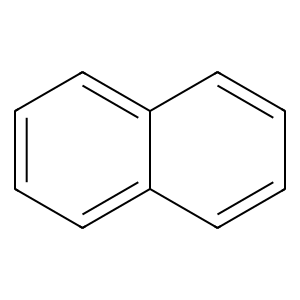

In [14]:
def mostrar_molecula (smile):
    mol = Chem.MolFromSmiles(smile)
    img = Draw.MolToImage(mol)
    display(img)   

def contar_anillos(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_anillos = len(Chem.GetSymmSSSR(mol))  # Obtener el número de sistemas de anillos(SSSR)
        return num_anillos
    else:
        return "Error al procesar la molécula"
        
# Test
naftaleno_smiles = "C1=CC=C2C=CC=CC2=C1"  # Naftaleno
# Aplicar la función para contar anillos en el naftaleno
num_anillos_naftaleno = contar_anillos(naftaleno_smiles)
# Mostrar el resultado
print(f"Número de anillos en Naftaleno ({naftaleno_smiles}): {num_anillos_naftaleno}")
mostrar_molecula(naftaleno_smiles)

### Aplicar al Df

In [15]:
# Aplicar la función a la columna SMILES para contar anillos  y crear una nueva columna en el DataFrame
df['N°Anillos'] = df['SMILES'].apply(contar_anillos)
# Mostrar el DataFrame con la nueva columna de número de anillos 
df.head()

,ChEBI ID,ChEBI Name,SMILES,deltag,SID,CID,N°Carbonos,N°Oxigenos,N°S,N°N,N°Anillos
0,177972,"3,4,5-trihydroxy-6-{[5,6,7-trihydroxy-2-(4-hyd...",O1C(OC2=C(OC3=C(C2=O)C(O)=C(O)C(O)=C3)C4=CC(OC...,-9.4,85377015,131835070,22,14,0,0,4
1,191634,Neoliquiritin 2''-apioside,O(C1C(O)C(O)C(OC1OC2=CC=3OC(CC(=O)C3C=C2)C4=CC...,-9.9,85390422,131752849,26,13,0,0,5
2,186794,Haploside F,O(C1[C@@H](O)[C@H](O)C(O[C@H]1OC2=C(O)C=3OC(=C...,-10.3,85385648,44260005,28,17,0,0,5
3,197154,Sagittatoside A,O([C@@H]1[C@H](O)[C@@H](O)[C@@H](O[C@H]1OC2=C(...,-10.6,85395895,13916054,33,15,0,0,5
4,188752,Diosmetin 7-O-beta-D-glucopyranoside,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC=2...,-9.0,85387578,11016019,22,11,0,0,4


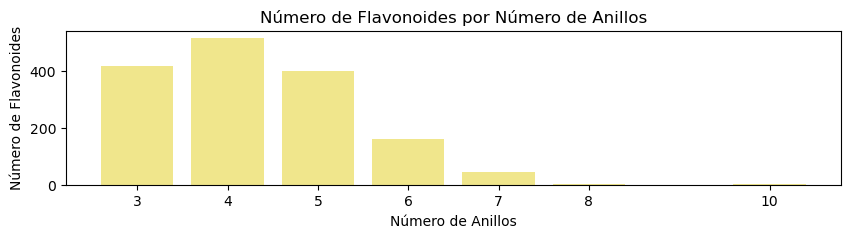

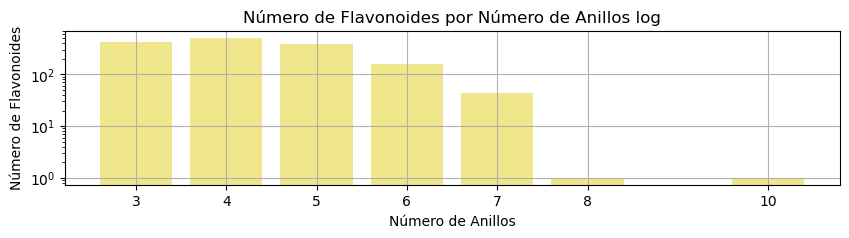

In [16]:
# Generar DataFrame agrupado por N° de Anillos "Groupby" 
grupos_por_anillos = df.groupby('N°Anillos').size()

# Graficar Df Anillos
plt.figure(figsize=(10, 2))
plt.bar(grupos_por_anillos.index, grupos_por_anillos.values, color='khaki')
plt.xlabel('Número de Anillos')
plt.ylabel('Número de Flavonoides')
plt.title('Número de Flavonoides por Número de Anillos')
plt.xticks(grupos_por_anillos.index) #Generar etiqueta en eje X solo si hay resultados
plt.grid(False)
plt.show()

# Graficar en escala logaritmica
plt.figure(figsize=(10, 2))
plt.bar(grupos_por_anillos.index, grupos_por_anillos.values, color='khaki')
plt.xlabel('Número de Anillos')
plt.ylabel('Número de Flavonoides')
plt.title('Número de Flavonoides por Número de Anillos log')
plt.xticks(grupos_por_anillos.index)
plt.grid(True)
plt.yscale('log')
# Mostrar
plt.show()

### Eliminar Outliers

Nombre de Molecula:
90    8-[6-(3-{[6-O-(6-deoxy-alpha-L-mannopyranosyl)...
Name: ChEBI Name, dtype: object


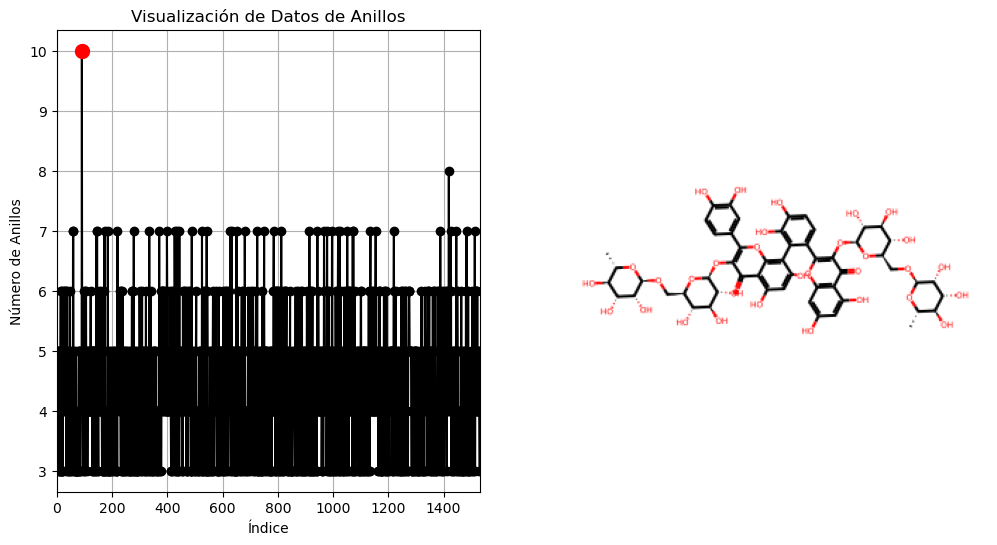

Se borro la molecula con indice : [90]


In [17]:
# Transformamos la columna de interes a array para visualizar de otra manera y obtener el índice
num_anillos_array = df['N°Anillos'].to_numpy()
# Obtener el índice del valor 10 en el array de la columna 'N°Anillos'
indice_molecula_10 = np.where(num_anillos_array == 10)[0]
#Encontrar índice
smiles_flavonoide_10 = df.loc[indice_molecula_10]['SMILES'].values[0]
# Crear un objeto Mol desde el SMILES y mostrar
mol = Chem.MolFromSmiles(smiles_flavonoide_10)
imagen_flavonoide_10 = plot_molecula(smiles_flavonoide_10)

# Buscar el nombre de Flavonoide con indice 90
print("Nombre de Molecula:")
print(df.iloc[indice_molecula_10, 1])

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Visualizar los datos en el array en el primer subplot (a la izquierda)
ax1.plot(num_anillos_array, marker='o', color='black')
ax1.set_xlabel('Índice')
ax1.set_ylabel('Número de Anillos')
ax1.set_title('Visualización de Datos de Anillos')
ax1.grid(True)
ax1.set_xlim(0, 1531)
# Marcar en rojo el índice 10 en el gráfico
ax1.plot(indice_molecula_10, num_anillos_array[indice_molecula_10], marker='o', color='red', markersize=10)
#Subplot 2 = Molecula 10 anillos
ax2.imshow(imagen_flavonoide_10)
ax2.axis('off')  # Desactivar ejes en el segundo subplot
#Mostrar Plot
plt.show()

#Eliminar molecula:
print(f"Se borro la molecula con indice : {indice_molecula_10}")
df = df.drop(index=indice_molecula_10)
df = df.reset_index(drop=True)

Nombre de Molecula:
1418    6-{[2-(4-{[3-({3,4-dihydroxy-4-[(1H-indole-3-c...
Name: ChEBI Name, dtype: object


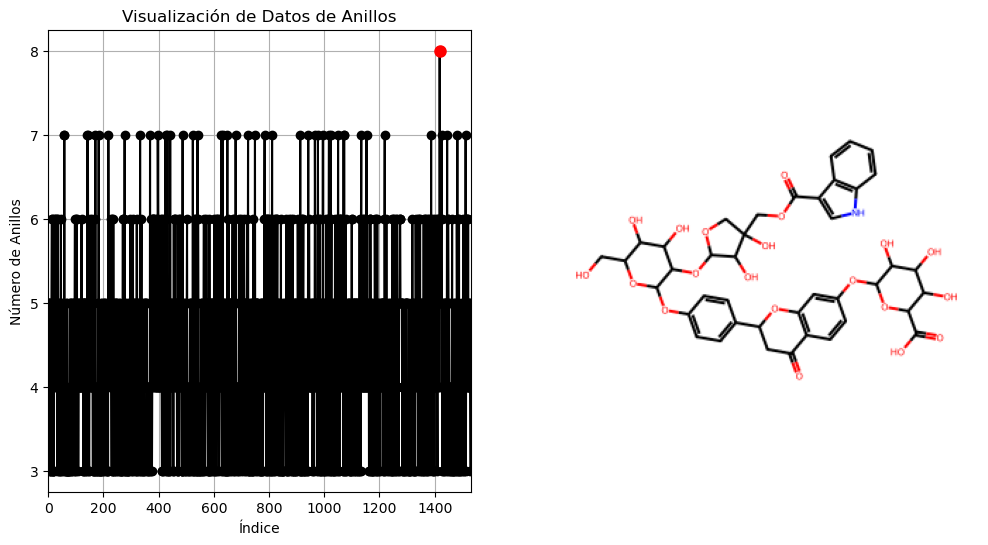

Se borro la molecula con indice : 1419


In [18]:
# Transformamos la columna de interes a array para visualizar de otra manera y obtener el índice
num_anillos_array = df['N°Anillos'].to_numpy()
# Obtener el índice del valor 8 en el array de la columna 'N°Anillos'
indice_molecula_8 = np.where(num_anillos_array == 8)[0]
#Encontrar índice
smiles_flavonoide_8 = df.loc[indice_molecula_8]['SMILES'].values[0]
# Crear un objeto Mol desde el SMILES y mostrar
mol = Chem.MolFromSmiles(smiles_flavonoide_8)
imagen_flavonoide_8 = plot_molecula(smiles_flavonoide_8)

# Buscar el nombre de Flavonoide con indice 90
print("Nombre de Molecula:")
print(df.iloc[indice_molecula_8, 1])

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Visualizar los datos en el array en el primer subplot (a la izquierda)
ax1.plot(num_anillos_array, marker='o', color='black')
ax1.set_xlabel('Índice')
ax1.set_ylabel('Número de Anillos')
ax1.set_title('Visualización de Datos de Anillos')
ax1.grid(True)
ax1.set_xlim(0, 1531)
# Marcar en rojo el índice 8 en el gráfico
ax1.plot(indice_molecula_8, num_anillos_array[indice_molecula_8], marker='o', color='red', markersize=8)
#Subplot 2 = Molecula 8 anillos
ax2.imshow(imagen_flavonoide_8)
ax2.axis('off')  # Desactivar ejes en el segundo subplot
#Mostrar Plot
plt.show()

#Eliminar molecula:
print(f"Se borro la molecula con indice : 1419")
df = df.drop(index=indice_molecula_8)
df = df.reset_index(drop=True)

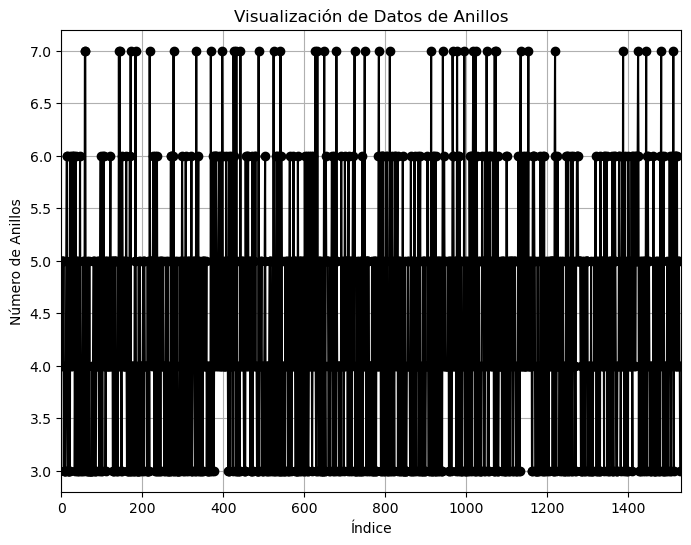

In [19]:
# Transformamos la columna de interes a array para visualizar de otra manera y obtener el índice
num_anillos_array = df['N°Anillos'].to_numpy()
# Plot
plt.figure(figsize=(8, 6))
plt.plot(num_anillos_array, marker='o', color='black')
plt.xlabel('Índice')
plt.ylabel('Número de Anillos')
plt.title('Visualización de Datos de Anillos')
plt.grid(True)
plt.xlim(0, 1531)
plt.show()

# Conteo de anillos aromáticos
_____________________________________________________________________________________________________________

### RDkit nos permite crear formulas para detectar la aromaticidad de los anillos de nuestras moleculas
###### Fuente : https://sourceforge.net/p/rdkit/mailman/message/23801106/
___________________________________________________________________________________________________________________________________________________

### Test contar anillos aromáticos:

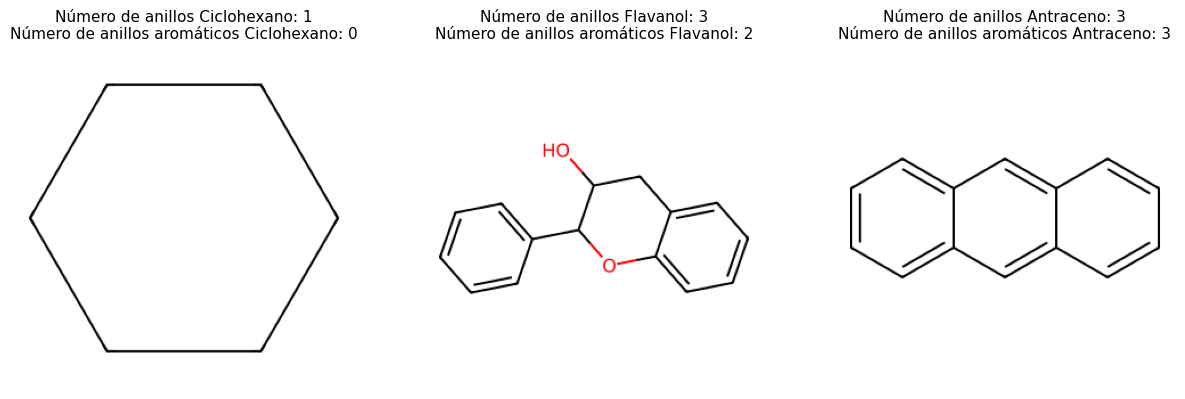

In [20]:
def contar_aromaticos(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return "Error al procesar la molécula"
    ring_info = mol.GetRingInfo()
    atom_rings = ring_info.AtomRings()
    bond_rings = ring_info.BondRings()
    anillos_aromaticos = 0
    for bond_ring in bond_rings:
        aromatico = True
        for bond_idx in bond_ring:
            if not mol.GetBondWithIdx(bond_idx).GetIsAromatic():
                aromatico = False
                break
        if aromatico:
            anillos_aromaticos += 1
    return anillos_aromaticos
    
#Moleculas Test Anillo Aromático
#----------------------------------------Ciclohexano
Ciclohexanosmile = 'C1CCCCC1'  # Ejemplo de ciclohexano
imagenciclohexano = plot_molecula(Ciclohexanosmile)
#Contar anillos
anillos_ciclohexano = contar_anillos(Ciclohexanosmile)
#Contar anillos aromáticos
aromaticos_ciclohexano = contar_aromaticos(Ciclohexanosmile)
#----------------------------------------Flavonol
Flavonolsmile = "C1C(C(OC2=CC=CC=C21)C3=CC=CC=C3)O"
imagenflavonol = plot_molecula(Flavonolsmile)
#Contar anillos
anillos_flavonol = contar_anillos(Flavonolsmile)
#Contar anillos aromáticos
aromaticos_flavonol = contar_aromaticos(Flavonolsmile)
#----------------------------------------Antraceno
Antracenosmile = "C1=CC2=CC3=CC=CC=C3C=C2C=C1"
imagenantraceno = plot_molecula(Antracenosmile)
#Contar anillos
anillos_antraceno = contar_anillos(Antracenosmile)
#Contar anillos aromáticos
aromaticos_antraceno = contar_aromaticos(Antracenosmile)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Ajusta el tamaño de la figura
# Subplot 1 = Calcular enlaces dobles Flavanona
axs[0].imshow(imagenciclohexano)
axs[0].set_title(f"Número de anillos Ciclohexano: {anillos_ciclohexano}\nNúmero de anillos aromáticos Ciclohexano: {aromaticos_ciclohexano}", fontsize=11)
axs[0].axis('off')
# Subplot 2 = Calcular enlaces dobles Flavanol
axs[1].imshow(imagenflavonol)
axs[1].axis('off')
axs[1].set_title(f"Número de anillos Flavanol: {anillos_flavonol}\nNúmero de anillos aromáticos Flavanol: {aromaticos_flavonol}",fontsize=11)
#Subplot 3 = Calcular enlaces dobles Nitrisona
axs[2].imshow(imagenantraceno)
axs[2].axis('off')
axs[2].set_title(f"Número de anillos Antraceno: {anillos_antraceno}\nNúmero de anillos aromáticos Antraceno: {aromaticos_antraceno}",fontsize=11)
#Mostrar Plot
plt.show()

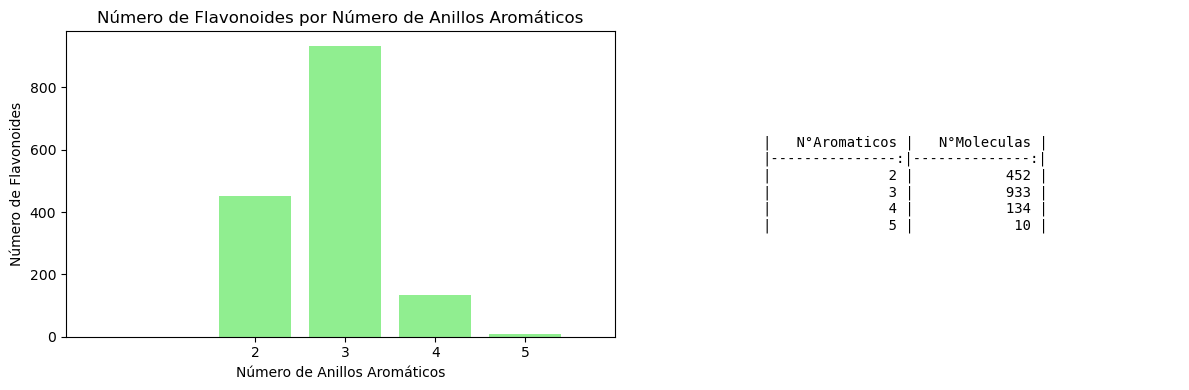

In [21]:
# Aplicar la función a la columna SMILES del Df para contar el número de anillos aromáticos
df['N°Aromaticos'] = df['SMILES'].apply(contar_aromaticos)

# Agrupar por el número de anillos aromáticos y contar el número de moléculas en cada grupo
grupos_por_aromaticos = df.groupby('N°Aromaticos').size()

# Convertir la Serie en un DataFrame
df_resultado_aromatico = grupos_por_aromaticos.reset_index()
df_resultado_aromatico.columns = ["N°Aromaticos", "N°Moleculas"]
# Convertir el DataFrame a formato Markdown
df_resultado_md = df_resultado_aromatico.to_markdown(index=False)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# Subplot 1 = N° Anillos Aromáticos en el Df
ax1.bar(df_resultado_aromatico['N°Aromaticos'], df_resultado_aromatico['N°Moleculas'], color='lightgreen')
ax1.set_xlabel('Número de Anillos Aromáticos')
ax1.set_ylabel('Número de Flavonoides')
ax1.set_title('Número de Flavonoides por Número de Anillos Aromáticos')
ax1.set_xticks(df_resultado_aromatico['N°Aromaticos'])
ax1.grid(False)  # Desactivar las cuadrículas en el gráfico
ax1.set_xlim(-0.1, len(df_resultado_aromatico) + 2)
# Subplot 2 = Markdown
ax2.axis('off')  # Desactivar ejes en el segundo subplot
ax2.text(0.5, 0.5, df_resultado_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
# Agrandar el eje x en el gráfico de barras
plt.tight_layout()
plt.show()

# Clasificación por subestructuras
____________________________________________________________________________________________________________________________________
Gracias a RDkit podemos clasificar nuestro dataframe segun las estructuras primarias de los flavonoides
Álvarez Castro, E., & Orallo Cambeiro, F. (2003). Actividad biológica de los flavonoides (I). Acción frente al cáncer. Offarm, 22(10), 130–140. https://www.elsevier.es/es-revista-offarm-4-articulo-actividad-biologica-flavonoides-i-accion-13054406
________________________________________________________________________________________________________________________________________________________

### Isoflavonas:

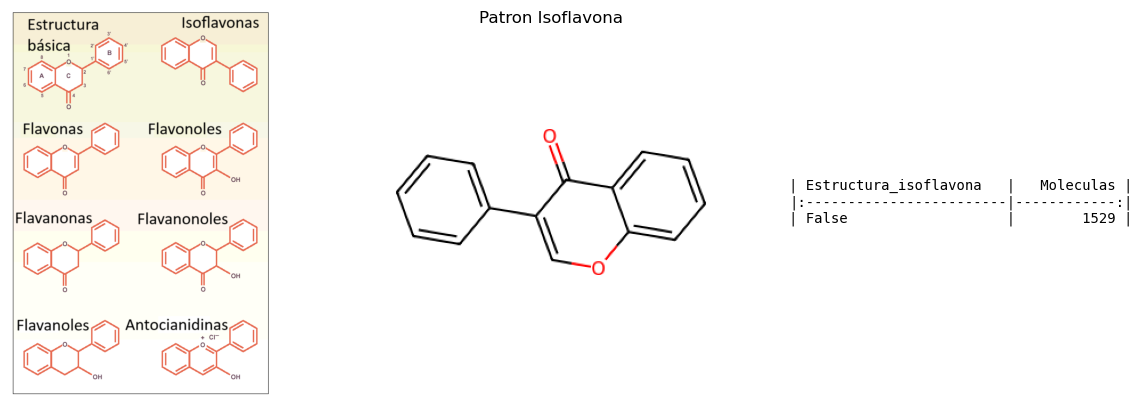

In [22]:
from PIL import Image
def verificar_isoflavona(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_isoflavona)
    else:
        return False  # Si la molécula no se puede convertir, asumimos que no contiene la isoflavona

#Patron Isoflavona
smiles_isoflavona = "C1=CC=C(C=C1)C2=COC3=CC=CC=C3C2=O"
imagen_isoflavona = plot_molecula(smiles_isoflavona)
patron_isoflavona = Chem.MolFromSmiles(smiles_isoflavona)

# Aplicar la función a la columna SMILES para verificar si es o no_isoflavona
df['Estructura_isoflavona'] = df['SMILES'].apply(verificar_isoflavona)
#Agrupar
grupo_isoflavona = df.groupby('Estructura_isoflavona').size()
grupo_isoflavona_md = grupo_isoflavona.reset_index().rename(columns={0: 'Moleculas'}).to_markdown(index=False)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Ajusta el tamaño de la figura
# Subplot 1 = Cargar y mostrar la imagen de flavonoides
ruta_imagen = "imgs/flavsimg.png"
imagen = Image.open(ruta_imagen)
axs[0].imshow(imagen)
axs[0].axis('off')
# Subplot 2 = Isoflavona
axs[1].imshow(imagen_isoflavona)
axs[1].set_title("Patron Isoflavona")
axs[1].axis('off')
#Subplot 3 = Mostrar Markdown
axs[2].axis('off')
axs[2].text(0.5, 0.5, grupo_isoflavona_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
#Mostrar Plot
plt.show()

### Test detectar estructura Isoflavona:
###### Ya que no se detectaron vamos a testear nuestra función:
###### (CTRL + ENTER para actualizar moleculas)

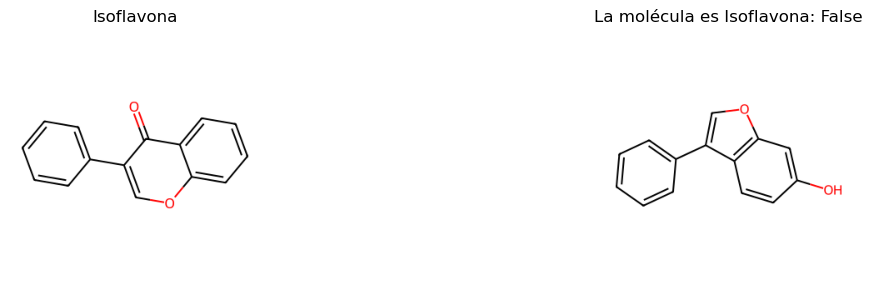

In [23]:
import random
# Lista de moléculas
moleculas = [
    "C1CC2=C(C1)C(=O)C3=C(C2=O)C=C(C=C3)O",
    "C1=CC=C(C=C1)C2=COC3=C2C=CC(=C3)O",
    "COC1=CC=C(C=C1)C2=COC3=C(C2=O)C=CC(=C3)O",
    "OC1=CC=C(C=C1)C1=COC2=CC(O)=CC(O)=C2C1=O"
]
# Seleccionar una molécula aleatoria y verificar
smiles_molecula_aleatoria = random.choice(moleculas)
imagen_test_isoflavona = plot_molecula(smiles_molecula_aleatoria)
es_isoflavona = verificar_isoflavona(smiles_molecula_aleatoria)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 3))  # Ajusta el tamaño de la figura
# Subplot 1 = Isoflavona
axs[0].imshow(imagen_isoflavona)
axs[0].set_title("Isoflavona")
axs[0].set_axis_off()
# Subplot 1 = Test
axs[1].imshow(imagen_test_isoflavona)
axs[1].set_title(f"La molécula es Isoflavona: {es_isoflavona}")
axs[1].set_axis_off()
#Mostrar Plot
plt.tight_layout()
plt.show()

### Isoflavanonas
____________________________________________________________________________________________________

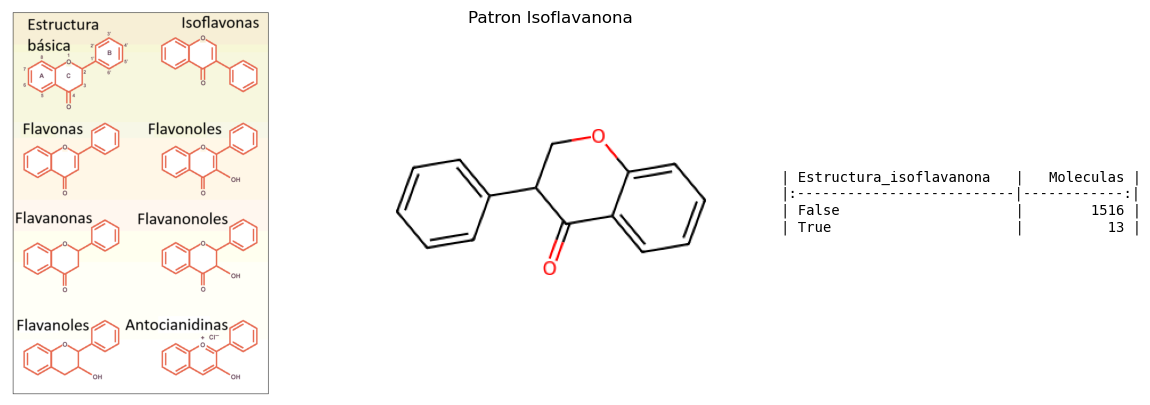

In [24]:
#Ahora vamos a buscar Isoflavanonas
def verificar_isoflavanona(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_isoflavanona)
    else:
        return False  # Si la molécula no se puede convertir, asumimos que no contiene el isoflavanona
        
#Buscar Isoflavonas
smiles_isoflavanona = "C1C(C(=O)C2=CC=CC=C2O1)C3=CC=CC=C3"
imagen_isoflavanona = plot_molecula(smiles_isoflavanona)
patron_isoflavanona = Chem.MolFromSmiles(smiles_isoflavanona)
# Aplicar la función a la columna SMILES para verificar si es o no_isoflavanona
df['Estructura_isoflavanona'] = df['SMILES'].apply(verificar_isoflavanona)
#Agrupar
grupo_isoflavanona = df.groupby('Estructura_isoflavanona').size()
grupo_isoflavanona_md = grupo_isoflavanona.reset_index().rename(columns={0: 'Moleculas'}).to_markdown(index = False)

#Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Ajusta el tamaño de la figura
# Subplot 1 = Cargar y mostrar la imagen de flavonoides
ruta_imagen = "imgs/flavsimg.png"
imagen = Image.open(ruta_imagen)
axs[0].imshow(imagen)
axs[0].axis('off')
# Subplot 2 = Isoflavanona
axs[1].imshow(imagen_isoflavanona)
axs[1].set_title("Patron Isoflavanona")
axs[1].axis('off')
#Subplot 3 = Mostrar Markdown
axs[2].axis('off')
axs[2].text(0.5, 0.5, grupo_isoflavanona_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
# Mostrar el gráfico
plt.show()

#### Si Estructura_isoflavanona = True nombramos como isoflavanona nuestras moleculas

In [25]:
df['Tipo_flavonoide'] = ''
# Obtener el valor actual de 'Tipo_flavonoide' si no cumple ninguna condición
valor_actual = df['Tipo_flavonoide']
#Conseguir índices de isoflavanonas
indices_isoflavanona = df[df['Estructura_isoflavanona'] == True].index.tolist()
condiciones = [
    (df['Estructura_isoflavanona'] == True)
]
# Valores correspondientes a las condiciones
valores = ['Isoflavanona']
# Asignar valores a la columna 'Tipo_flavonoide' según las condiciones sin modificar los valores actuales
df['Tipo_flavonoide'] = np.select(condiciones, valores, default=valor_actual)
# Verificar el resultado
df.loc[indices_isoflavanona, ['SMILES', 'ChEBI Name', 'Estructura_isoflavanona', 'Tipo_flavonoide']].sample(n=10)

,SMILES,ChEBI Name,Estructura_isoflavanona,Tipo_flavonoide
537,O1CC(C(=O)C=2C1=C(C(O)=CC2O)C)C3=CC=C(OC)C=C3,"5,7-Dihydroxy-4'-methoxy-8-methylisoflavanone",True,Isoflavanona
41,O1CC(C2=CC=C(OC)C=C2)C(=O)C3=C1C=C(O)C=C3,Dihydroformononetin,True,Isoflavanona
1352,O1CC(C2=C(OC)C(OC)=C(O)C=C2)C(=O)C3=C1C=C(O)C=C3,Lespedeol C,True,Isoflavanona
10,O1CC(C(=O)C2=C1C(=C(OC)C=C2O)C)C3=CC(OC)=CC=C3,5-hydroxy-7-methoxy-3-(3-methoxyphenyl)-8-meth...,True,Isoflavanona
362,O1CC(C2=C(OC)C=C(OC)C=C2)C(=O)C3=C1C=C(O)C=C3,Sativanone,True,Isoflavanona
300,O1CC(C2=C(OC)C=C(O)C=C2)C(=O)C3=C1C=C(O)C=C3OC,"4',7-Dihydroxy-2',5-dimethoxyisoflavanone",True,Isoflavanona
1068,O1CC(C(=O)C=2C1=CC(O)=C(OC)C2)C3=CC=C(O)C=C3,Dihydroglycitein,True,Isoflavanona
1321,C=1(C=C(C2=C(C1)OCC(C2=O)C=3C(=C(C(=CC3)O)OC)O...,parvisoflavanone,True,Isoflavanona
1493,O1CC(O)(C2=C(O)C=C(OC)C=C2)C(=O)C3=C1C=C(O)C=C3,"4'-Methoxy-2',3,7-trihydroxyisoflavanone",True,Isoflavanona
661,O1CC(C(=O)C2=C1C=C3OC=CC3=C2)C4=C(OC)C=C(OC)C=C4,Neoraunone,True,Isoflavanona


### Test clasificación isoflavanona:
____________________________________________________________________________________________________
##### Vemos si nuestras moleculas clasificadas como isoflavanonas cumplen con la clasificación
###### (CTRL + ENTER para actualizar isoflavanona)

SMILES                     O1CC(C(=O)C=2C1=CC(O)=C(OC)C2)C3=CC=C(O)C=C3
ChEBI Name                                             Dihydroglycitein
Estructura_isoflavanona                                            True
Name: 1068, dtype: object


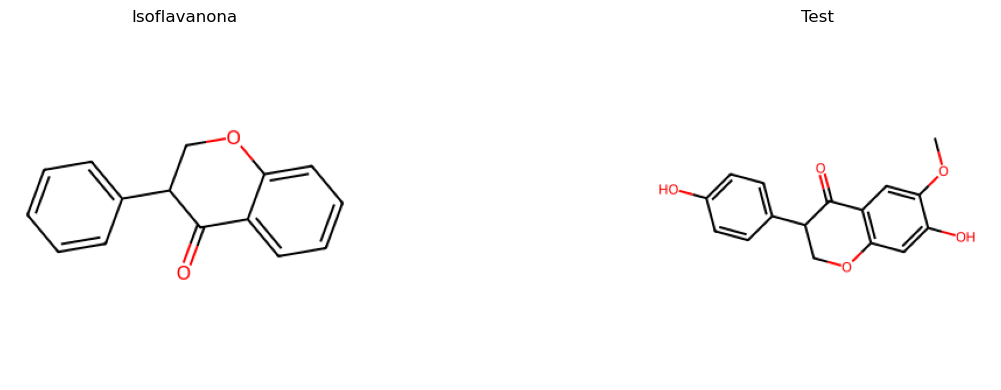

In [26]:
#Testear las Isoflavanonas clasificadas
test_isoflavanona = random.choice(indices_isoflavanona)
# Verificar Moleculas
print(df.loc[test_isoflavanona, ['SMILES', 'ChEBI Name', 'Estructura_isoflavanona']])
#Visualizar
smiles_molecula = df.loc[test_isoflavanona, 'SMILES']
imagen_isoflavanona_test = plot_molecula(smiles_molecula)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 4))  # Ajusta el tamaño de la figura
# Subplot 1 = Isoflavanona
axs[0].imshow(imagen_isoflavanona)
axs[0].set_title("Isoflavanona")
axs[0].set_axis_off()
# Subplot 2 = Test
axs[1].imshow(imagen_isoflavanona_test)
axs[1].set_title("Test")
axs[1].set_axis_off()
#Mostrar Plot
plt.tight_layout()
plt.show()

### Flavonas y Flavonoles
____________________________________________________________________________________________________
#### Flavonas y Flavonoles comparten el mismo esqueleto, por lo que teoricamente debemos encontrar mas Flavonas que Flavonoles 
____________________________________________________________________________________________________
### Flavonas

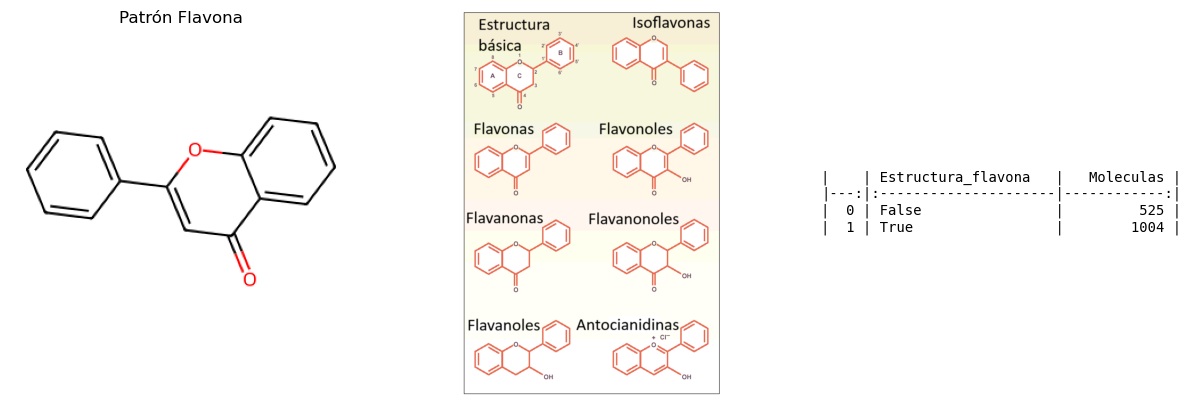

In [27]:
def verificar_flavona(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_flavona)
    else:
        return False  

#Patron Flavona
smiles_flavona = "C1=CC=C(C=C1)C2=CC(=O)C3=CC=CC=C3O2"
imagen_flavona = plot_molecula(smiles_flavona)
patron_flavona = Chem.MolFromSmiles(smiles_flavona)
# Aplicar la función a la columna SMILES para verificar si es o no Flavona
df['Estructura_flavona'] = df['SMILES'].apply(verificar_flavona)
grupo_flavona = df.groupby('Estructura_flavona').size()
grupo_flavona_md = grupo_flavona.reset_index().rename(columns={0: 'Moleculas'}).to_markdown()

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Ajusta el tamaño de la figura
# Eliminar los ejes de todas las imágenes
for ax in axs:
    ax.axis('off')
#Subplot 1 = "Flavona"
axs[0].set_title("Patrón Flavona")  # Título para la imagen 1
axs[0].imshow(imagen_flavona)
#Subplot 2 = "Estructura flavonoides"
imagen = Image.open(ruta_imagen)
axs[1].imshow(imagen)
# Subplot 3 = Markdown
axs[2].text(0.5, 0.5, grupo_flavona_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
# Mostrar el gráfico
plt.show()

### Flavonoles
____________________________________________________________________________________________________

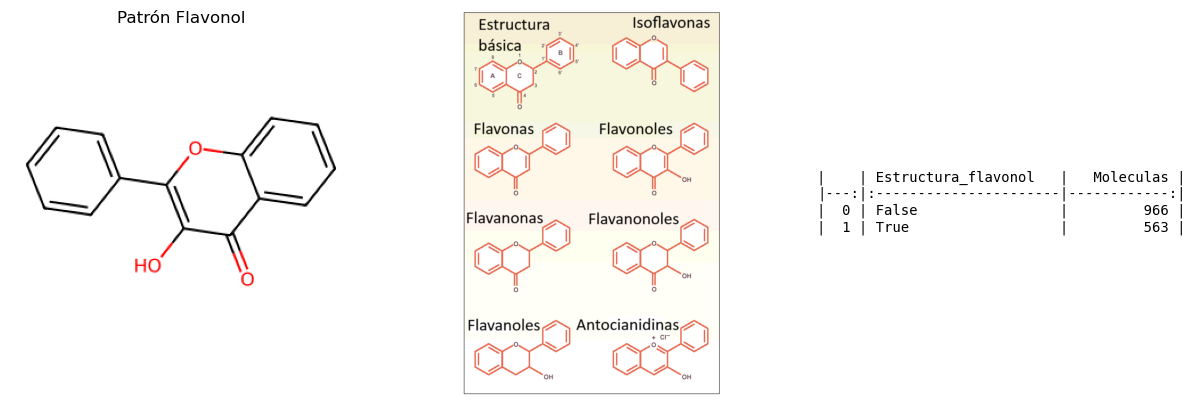

In [28]:
def verificar_flavonol(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_flavonol)
    else:
        return False  
        
smiles_flavonol =("C1=CC=C(C=C1)C2=C(C(=O)C3=CC=CC=C3O2)O")
imagen_flavonol = plot_molecula(smiles_flavonol)
patron_flavonol = Chem.MolFromSmiles(smiles_flavonol)
# Aplicar la función a la columna SMILES para verificar si es o no flavonol
df['Estructura_flavonol'] = df['SMILES'].apply(verificar_flavonol)
grupo_flavonol = df.groupby('Estructura_flavonol').size()
grupo_flavonol_md = grupo_flavonol.reset_index().rename(columns={0: 'Moleculas'}).to_markdown()

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Ajusta el tamaño de la figura
# Eliminar los ejes de todas las imágenes
for ax in axs:
    ax.axis('off')
#Subplot 1 = "Flavonol
axs[0].set_title("Patrón Flavonol")  # Título para la imagen 
axs[0].imshow(imagen_flavonol)
# Subplot 2 = "Estructura flavonoides
imagen = Image.open(ruta_imagen)
axs[1].imshow(imagen)
# Subplot 3 = Markdown
axs[2].text(0.5, 0.5, grupo_flavonol_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
# Mostrar el gráfico
plt.show()

##### De esta manera si Estructura_flavona = True & Estructura_flavonol = False entonces la molecula es Flavona
##### Por el contrario si Estructura_flavona = True & Estructura_flavonol = True entonces la molecula es Flavonol
###### (CTRL + ENTER para generar nueva muestra del df)

In [29]:
valor_actual = df['Tipo_flavonoide']
#Condiciones
condiciones = [
    (df['Estructura_flavona'] == True) & (df['Estructura_flavonol'] == False),
    (df['Estructura_flavona'] == True) & (df['Estructura_flavonol'] == True)
]
# Valores correspondientes a las condiciones
valores = ['Flavona', 'Flavonol']
# Asignar valores a la columna 'Tipo_flavonoide' según las condiciones sin modificar los valores actuales
df['Tipo_flavonoide'] = np.select(condiciones, valores, default=valor_actual)
#Mostrar muestra de Dataframe
df[['Estructura_flavona', 'Estructura_flavonol', 'Tipo_flavonoide']].sample(n=10)

,Estructura_flavona,Estructura_flavonol,Tipo_flavonoide
1063,True,True,Flavonol
1232,True,False,Flavona
655,True,False,Flavona
1214,True,True,Flavonol
652,True,False,Flavona
1176,True,True,Flavonol
1264,True,False,Flavona
841,True,True,Flavonol
128,False,False,
1416,True,True,Flavonol


### Test Flavonas clasificadas
###### (CTRL + ENTER para actualizar molecula)

SMILES                O1C=2C(=C(O)C(=C(OC)C2)C)C(=O)C=C1C3=CC=CC=C3
ChEBI Name                      5-Hydroxy-7-methoxy-6-methylflavone
Estructura_flavona                                             True
Name: 1004, dtype: object


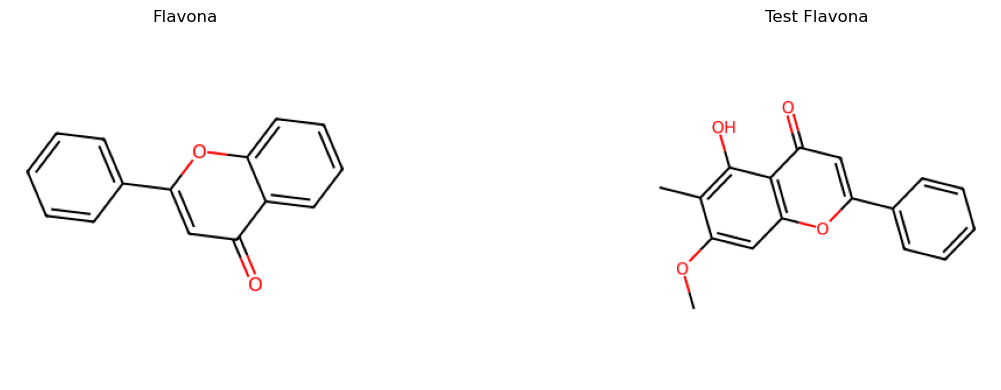

In [30]:
indices_flavona = df[df['Tipo_flavonoide'] == 'Flavona'].index.tolist()
#Flavona Aleatorio
test_flavona = random.choice(indices_flavona)
#Obtener imagen 
smiles_molecula_flavona = df.loc[test_flavona, 'SMILES']
imagen_flavona_test = plot_molecula(smiles_molecula_flavona)
# Info Molecula
print(df.loc[test_flavona, ['SMILES', 'ChEBI Name', 'Estructura_flavona']])

# Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 4))  # Ajusta el tamaño de la figura
# Subplot 1 = Flavona
axs[0].imshow(imagen_flavona)
axs[0].set_title("Flavona")
axs[0].set_axis_off()
# Subplot 2 = Test
axs[1].imshow(imagen_flavona_test)
axs[1].set_title("Test Flavona")
axs[1].set_axis_off()
#Mostrar Plot
plt.tight_layout()
plt.show()

### Test Flavonoles clasificados
###### (CTRL + ENTER para actualizar molecula)

SMILES                 O1C([C@@H](O)[C@H](O)C(O)[C@@H]1OC=2C=C3OC(=C(...
ChEBI Name                     Quercetin 3,3'-dimethyl ether 7-glucoside
Estructura_flavonol                                                 True
Name: 909, dtype: object


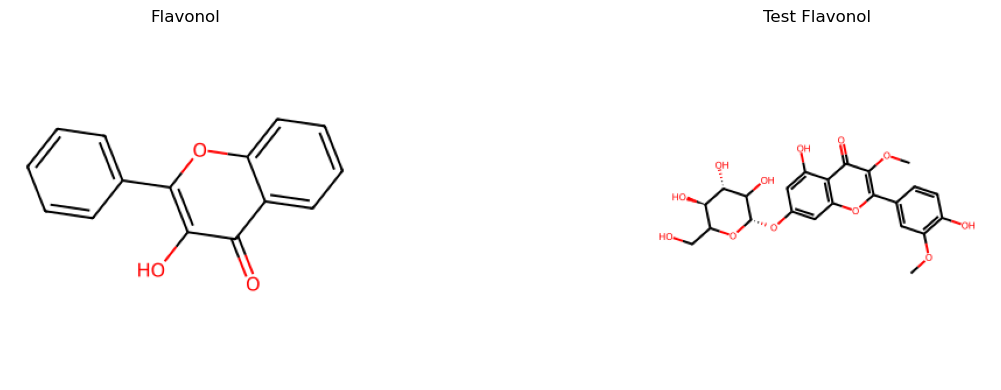

In [31]:
indices_flavonol = df[df['Tipo_flavonoide'] == 'Flavonol'].index.tolist()
#Flavonol Aleatorio
test_flavonol = random.choice(indices_flavonol)
#Obtener imagen 
smiles_molecula_flavonol = df.loc[test_flavonol, 'SMILES']
imagen_flavonol_test = plot_molecula(smiles_molecula_flavonol)
# Info Molecula
print(df.loc[test_flavonol, ['SMILES', 'ChEBI Name', 'Estructura_flavonol']])

# Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 4))  # Ajusta el tamaño de la figura
# Subplot 1 = Flavonol
axs[0].imshow(imagen_flavonol)
axs[0].set_title("Flavonol")
axs[0].set_axis_off()
# Subplot 2 = Test
axs[1].imshow(imagen_flavonol_test)
axs[1].set_title("Test Flavonol")
axs[1].set_axis_off()
#Mostrar Plot
plt.tight_layout()
plt.show()

### Flavanonas y Flavanonoles:
____________________________________________________________________________________________________
##### Al igual que las Flavonas y Flavonoles, las  Flavanonas y Flavanonoles tambien comparten el mismo esqueleto, por lo que teoricamente debemos encontrar mas Flavanonas que Flavanonoles 
____________________________________________________________________________________________________
### Flavanonas

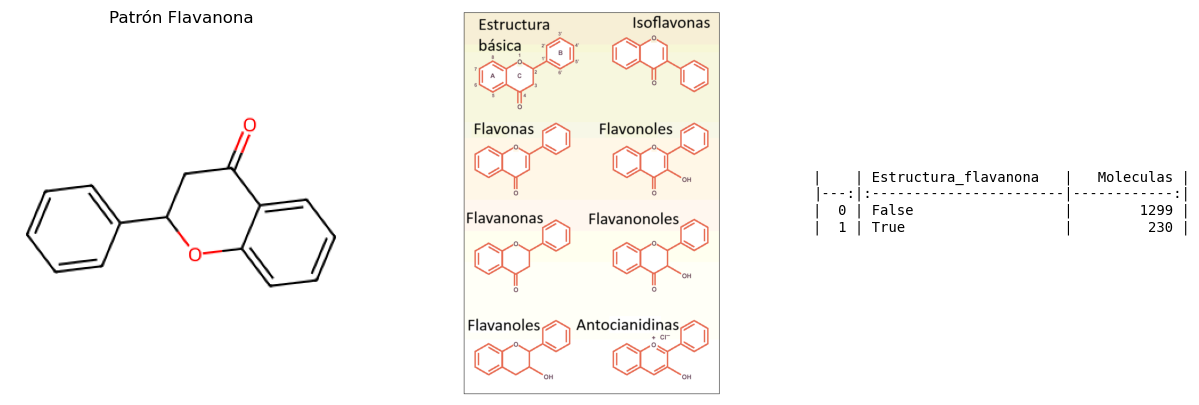

In [32]:
def verificar_flavanona(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_flavanona)
    else:
        return False  

smiles_flavanona =("C1C(OC2=CC=CC=C2C1=O)C3=CC=CC=C3")
imagen_flavanona = plot_molecula(smiles_flavanona)
patron_flavanona = Chem.MolFromSmiles(smiles_flavanona)
# Aplicar la función a la columna SMILES para verificar si es o no Flavonol
df['Estructura_flavanona'] = df['SMILES'].apply(verificar_flavanona)
grupo_flavanona = df.groupby('Estructura_flavanona').size()
grupo_flavanona_md = grupo_flavanona.reset_index().rename(columns={0: 'Moleculas'}).to_markdown()

#Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Ajusta el tamaño de la figura
# Eliminar los ejes de todas las imágenes
for ax in axs:
    ax.axis('off')
# Subplot 1 = "Flavanona"
axs[0].set_title("Patrón Flavanona")  # Título para la imagen 1
axs[0].imshow(imagen_flavanona)
# Subplot 2 = "Estructura Flavonoides"
imagen = Image.open(ruta_imagen)
axs[1].imshow(imagen)
# Subplot 3 = "Markdown"
axs[2].text(0.5, 0.5, grupo_flavanona_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
# Mostrar el gráfico
plt.show()

### Flavanonol

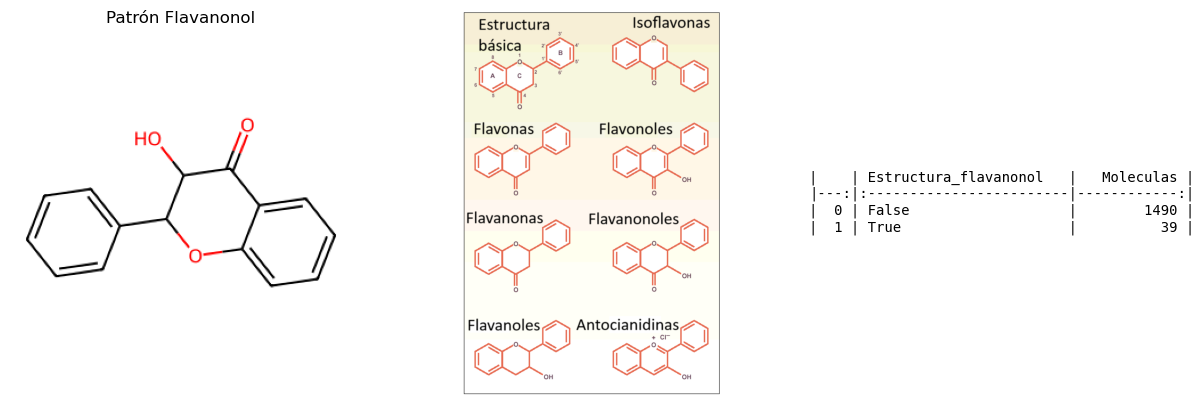

In [33]:
# Buscar flavanonol
# Función para verificar si una molécula contiene la estructura de la flavona
def verificar_flavanonol(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_flavanonol)
    else:
        return False  

# Buscar flavanonol
smiles_flavanonol =("C1(O)C(OC2=CC=CC=C2C1=O)C3=CC=CC=C3")
patron_flavanonol = Chem.MolFromSmiles(smiles_flavanonol)
imagen_flavanonol = plot_molecula(smiles_flavanonol)
# Aplicar la función a la columna SMILES para verificar si es o no Flavanonol
df['Estructura_flavanonol'] = df['SMILES'].apply(verificar_flavanonol)
grupo_flavanonol = df.groupby('Estructura_flavanonol').size()
grupo_flavanonol_md = grupo_flavanonol.reset_index().rename(columns={0: 'Moleculas'}).to_markdown()

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Ajusta el tamaño de la figura
# Eliminar los ejes de todas las imágenes
for ax in axs:
    ax.axis('off')
# Subplot 1 = "Flavanonol"
axs[0].set_title("Patrón Flavanonol")  # Título para la imagen 1
axs[0].imshow(imagen_flavanonol)
# Subplot 2 = "Estructura Flavonoides"
imagen = Image.open(ruta_imagen)
axs[1].imshow(imagen)
# Subplot 3 = "Markdown"
axs[2].text(0.5, 0.5, grupo_flavanonol_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
# Mostrar el gráfico
plt.show()

##### Si Estructura_flavanona = True & Estructura_flavanonol = False entonces la molecula es Flavanona
##### Por el contrario si Estructura_flavanona = True & Estructura_flavanonol = True entonces la molecula es Flavanonol
###### (CTRL + ENTER para generar nueva muestra del df)

In [34]:
# Condiciones para asignar valores a 'Tipo_flavonoide'
condiciones = [
    (df['Estructura_flavanona'] == True) & (df['Estructura_flavanonol'] == False),
    (df['Estructura_flavanona'] == True) & (df['Estructura_flavanonol'] == True)
]

# Valores correspondientes a las condiciones
valores = ['Flavanona', 'Flavanonol']
# Obtener el valor actual de 'Tipo_flavonoide' si no cumple ninguna condición
valor_actual = df['Tipo_flavonoide']
# Asignar valores a la columna 'Tipo_flavonoide' según las condiciones sin modificar los valores actuales
df['Tipo_flavonoide'] = np.select(condiciones, valores, default=valor_actual)
# Verificar el resultado
df[['Estructura_flavanona', 'Estructura_flavanonol', 'Tipo_flavonoide']].sample(n=10)

,Estructura_flavanona,Estructura_flavanonol,Tipo_flavonoide
1090,False,False,
59,False,False,Flavonol
740,True,False,Flavanona
1039,False,False,Flavona
1076,False,False,Flavona
16,False,False,
1049,False,False,Flavonol
1135,False,False,Flavona
1283,False,False,
1215,False,False,


### Test clasificacion Flavanona
###### (CTRL + ENTER para actualizar molecula)

SMILES                  O(C1[C@@H](O)[C@H](O)C(O[C@H]1OC2=CC=C([C@H]3O...
ChEBI Name              Liquiritigenin 7-glucoside-4'-apiosyl-(1->2)-g...
Estructura_flavanona                                                 True
Name: 1479, dtype: object


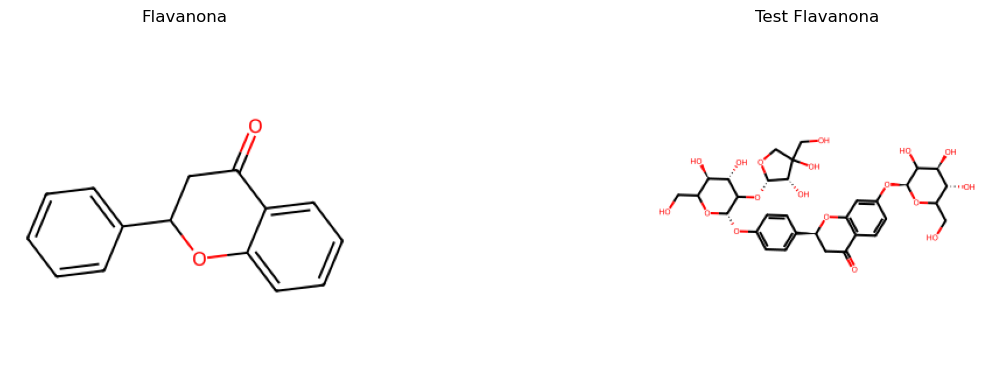

In [35]:
#Testear Flavanona
#Índices Flavanona
indices_flavanona = df[df['Tipo_flavonoide'] == 'Flavanona'].index.tolist()
#Flavanona Aleatorio
test_flavanona = random.choice(indices_flavanona)
#Obtener imagen 
smiles_molecula_flavanona = df.loc[test_flavanona, 'SMILES']
imagen_flavanona_test = plot_molecula(smiles_molecula_flavanona)
# Info Molecula
print(df.loc[test_flavanona, ['SMILES', 'ChEBI Name', 'Estructura_flavanona']])

# Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 4))  # Ajusta el tamaño de la figura
# Subplot 1 = Flavanona
axs[0].imshow(imagen_flavanona)
axs[0].set_title("Flavanona")
axs[0].set_axis_off()
# Subplot 2 = Test
axs[1].imshow(imagen_flavanona_test)
axs[1].set_title("Test Flavanona")
axs[1].set_axis_off()
#Mostrar Plot
plt.tight_layout()
plt.show()

### Test clasificacion Flavanonol
###### (CTRL + ENTER para actualizar molecula)

SMILES                   S(OC1C(OC=2C(C1=O)=C(O)C=C(O)C2)C3=CC(OC)=CC=C...
ChEBI Name               [5,7-dihydroxy-2-(3-methoxyphenyl)-4-oxo-3,4-d...
Estructura_flavanonol                                                 True
Name: 776, dtype: object


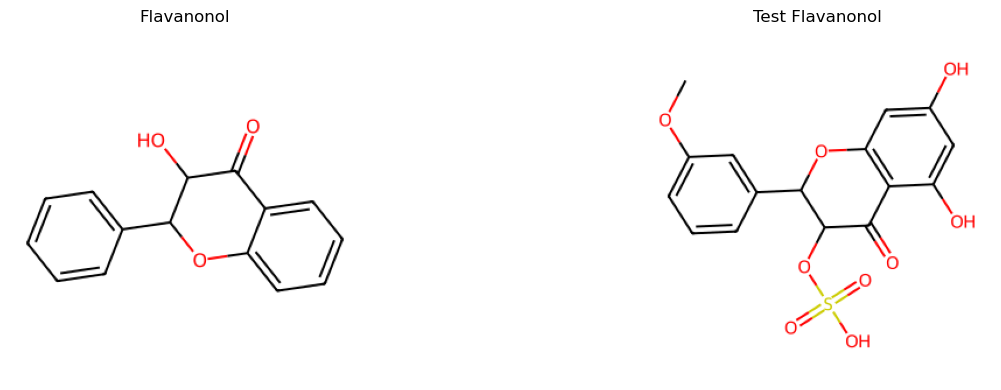

In [36]:
indices_flavanonol = df[df['Tipo_flavonoide'] == 'Flavanonol'].index.tolist()
#Flavanonol Aleatorio
test_flavanonol = random.choice(indices_flavanonol)
#Obtener imagen 
smiles_molecula_flavanonol = df.loc[test_flavanonol, 'SMILES']
imagen_flavanonol_test = plot_molecula(smiles_molecula_flavanonol)
# Info Molecula
print(df.loc[test_flavanonol, ['SMILES', 'ChEBI Name', 'Estructura_flavanonol']])

# Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 4))  # Ajusta el tamaño de la figura
# Subplot 1 = Flavanonol
axs[0].imshow(imagen_flavanonol)
axs[0].set_title("Flavanonol")
axs[0].set_axis_off()
# Subplot 2 = Test
axs[1].imshow(imagen_flavanonol_test)
axs[1].set_title("Test Flavanonol")
axs[1].set_axis_off()
#Mostrar Plot
plt.tight_layout()
plt.show()

#### Revisamos una muestra de nuestro dataframe y contamos las moleculas que nos quedan sin clasificar:

In [37]:
df[['ChEBI Name', 'SMILES', 'Tipo_flavonoide']].sample(n=10)

,ChEBI Name,SMILES,Tipo_flavonoide
1502,Isovitexin 2''-(6'''-p-coumaroylglucoside),O(C1C(O)C(O)C(OC1C2=C(O)C3=C(OC(=CC3=O)C4=CC=C...,Flavona
874,Quercetin 3-(6''-malonylgalactoside),O1[C@@H]([C@H](O)C(O)C(O)[C@@H]1OC2=C(OC=3C(C2...,Flavonol
350,Peonidin 3-(6''-caffeylgucoside),O1C([C@@H](O)C(O)C(O)[C@@H]1OC=2C(=[O+]C=3C(C2...,
1071,"5,7,2',5'-Tetrahydroxy-3,6,4'-trimethoxyflavone",O1C(C=2C(O)=CC(OC)=C(O)C2)=C(OC)C(=O)C3=C1C=C(...,Flavonol
821,Symplocoside,O1C([C@@H](O)[C@H](O)C(O)[C@@H]1OC=2C=C3O[C@@H...,
774,"3,3',4',5,6,8-Hexamethoxyflavone",O1C2=C(C(OC)=C(OC)C=C2OC)C(=O)C(OC)=C1C3=CC(OC...,Flavonol
1319,Apigenin 7-rhamnosyl-(1->6)-(4''-E-p-methoxyci...,O1C([C@@H](OC(=O)/C=C/C2=CC=C(OC)C=C2)[C@H](O)...,Flavona
671,Limocitrin 3-rhamnoside,O1C([C@H](O)C(O)[C@H](O)[C@@H]1OC2=C(OC3=C(C2=...,Flavonol
1229,"5-Hydroxy-2-(4-methoxyphenyl)-3-[3,4,5-trihydr...",O1C(C(O)C(O)C(O)C1OC=2C(=O)C=3C(OC2C4=CC=C(OC)...,Flavonol
732,Zapotinin,O1C(C2=C(OC)C=CC=C2OC)=CC(=O)C3=C1C=CC(OC)=C3O,Flavona


In [38]:
# Filtrar las filas donde 'Tipo_flavonoide' está vacío
indices_tipo_flavonoide_vacio = df[df['Tipo_flavonoide'] == ''].index

# Verificar los índices obtenidos
print(f"Existen {len(indices_tipo_flavonoide_vacio)} Moleculas sin clasificar")

Existen 282 Moleculas sin clasificar


#### De esta forma las moleculas que quedan sin clasificar seran clasificadas como "Flavanol" o como un grupo excedente llamado "Otros"
_______________________________________________________________________________________________________________________________________
### Flavanol

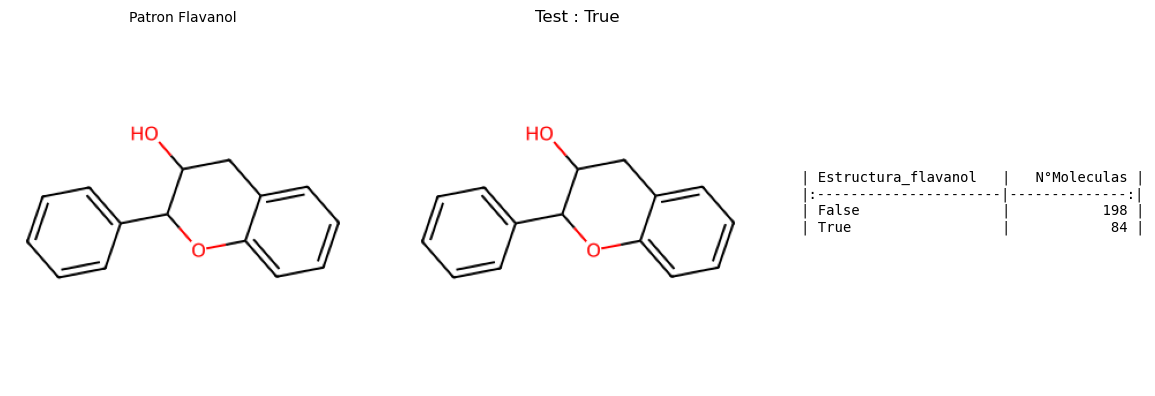

In [39]:
# Flavanol
def verificar_flavanol(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_flavanol)
    else:
        return False  
        
# Lista de moléculas
moleculas = [
    "O1C(C(O)C(O)C(O)C1CO)C2=C3OC(C(O)CC3=C(O)C(O)=C2O)C4=CC(O)=CC=C4",
    "C1C(OC2=CC=CC=C2C1=O)C3=CC=CC=C3",
    "C1=CC2=CC3=CC=CC=C3C=C2C=C1",
    "C1C(C(OC2=CC=CC=C21)C3=CC=CC=C3)O"
]

# Patrón Flavanol
smiles_flavanol =("C1C(C(OC2=CC=CC=C21)C3=CC=CC=C3)O")
imagen_flavanol = plot_molecula(smiles_flavanol)
patron_flavanol = Chem.MolFromSmiles(smiles_flavanol)
# Seleccionar una molécula aleatoria
smiles_molecula_aleatoria = random.choice(moleculas)
imagen_molecula = plot_molecula(smiles_molecula_aleatoria)
es_flavanol = verificar_flavanol(smiles_molecula_aleatoria)       

# Crear una máscara booleana para filtrar las moléculas con 0 enlaces dobles en oxígeno
mascarafiltro = df.index.isin(indices_tipo_flavonoide_vacio)
# Aplicar la función verificar_flavanol solo a las moléculas que cumplen con la condición
df.loc[mascarafiltro, 'Estructura_flavanol'] = df.loc[mascarafiltro, 'SMILES'].apply(verificar_flavanol)

#Md
grupo_flavanol = df.groupby('Estructura_flavanol').size()
grupo_flavanol_md = grupo_flavanol.reset_index(name="N°Moleculas").to_markdown(index=False)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Ajusta el tamaño de la figura
# Subplot 1 = Patron Flavanol
ax1 = axs[0]
ax1.imshow(imagen_flavanol)  
ax1.set_title("Patron Flavanol", fontsize=10)
#Subplot 2 = Test +
ax2 = axs[1]
ax2.imshow(imagen_molecula)
ax2.set_title(f"Test : {es_flavanol}", fontsize=12)
#Subplot 3 = Markdown
ax3 = axs[2]
ax3.text(0.5, 0.5, grupo_flavanol_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
#Mostrar Plot
plt.tight_layout()
plt.show()

In [40]:
# Filtrar las filas con índices en `indices_tipo_flavonoide_vacio` y donde 'Estructura_flavanol' sea True
df.loc[(mascarafiltro) & (df['Estructura_flavanol'] == True), 'Tipo_flavonoide'] = 'Flavanol'
# Filtrar las filas con índices en `indices_tipo_flavonoide_vacio` y donde 'Estructura_flavanol' sea False
df.loc[(mascarafiltro) & (df['Estructura_flavanol'] == False), 'Tipo_flavonoide'] = 'Otro'
#Array
array_tipos_flavonoide = np.array(df['Tipo_flavonoide'])
#Asignar valores
valores_flavanol = array_tipos_flavonoide == 'Flavanol'
valores_otro = array_tipos_flavonoide == 'Otro'
#Obtener índices
indices_flavanol = np.where(valores_flavanol)[0]
indices_otro = np.where(valores_otro)[0]

df[['ChEBI Name', 'SMILES', 'Tipo_flavonoide']].sample(n=10)


,ChEBI Name,SMILES,Tipo_flavonoide
1103,"5-hydroxy-7,8-dimethoxyflavanone 5-rhamnoside",O1C([C@H](O)[C@H](O)C(O)[C@@H]1OC=2C3=C(OC(CC3...,Flavanona
896,Isoferreirin,O1CC(C2=C(OC)C=C(O)C=C2)C(=O)C=3C1=CC(O)=CC3O,Isoflavanona
724,Quercetin 3-(6-[4-glucosyl-p-coumaryl]glucosyl...,O([C@H]1C(O)[C@@H](O)C(O[C@H]1OC2=C(OC=3C(C2=O...,Flavonol
1311,Gossypetin 8-glucuronide-3-sulfate,S(OC=1C(=O)C2=C(OC1C3=CC(O)=C(O)C=C3)C(O[C@@H]...,Flavonol
725,"6-Hydroxyluteolin 6,3'-dimethyl ether 7-sulfate",S(OC=1C=C2OC(C3=CC(OC)=C(O)C=C3)=CC(=O)C2=C(O)...,Flavona
84,"Kaempferol 7,4'-dimethyl ether 3-O-sulfate",S(OC1=C(OC=2C(C1=O)=C(O)C=C(OC)C2)C3=CC=C(OC)C...,Flavonol
231,"12-(3,4-dihydroxyphenyl)-13-hydroxy-6-(4-hydro...",O1C(OC2=C3C(CC(OC3=C4CC(O)C(OC4=C2)C5=CC(O)=C(...,Flavanol
233,"3,4,5-trihydroxy-6-{4-hydroxy-2-[3-(2-hydroxyp...",O1C(C(O)C(O)C(O)C1OC2=C(C(=O)CCC=3C(O)=CC=CC3)...,Otro
330,"5,7,2'-Trihydroxy-8,6'-dimethoxyflavone",O1C2=C(C(=O)C=C1C=3C(OC)=CC=CC3O)C(O)=CC(O)=C2OC,Flavona
711,"6-[6-carboxy-4,5-dihydroxy-2-[5-hydroxy-2-(4-h...",O(C1C(O)C(O)C(OC1OC=2C=C3OC(=CC(=O)C3=C(O)C2)C...,Flavona


### Test clasificacion Flavanol y Otros
###### (CTRL + ENTER para actualizar molecula)

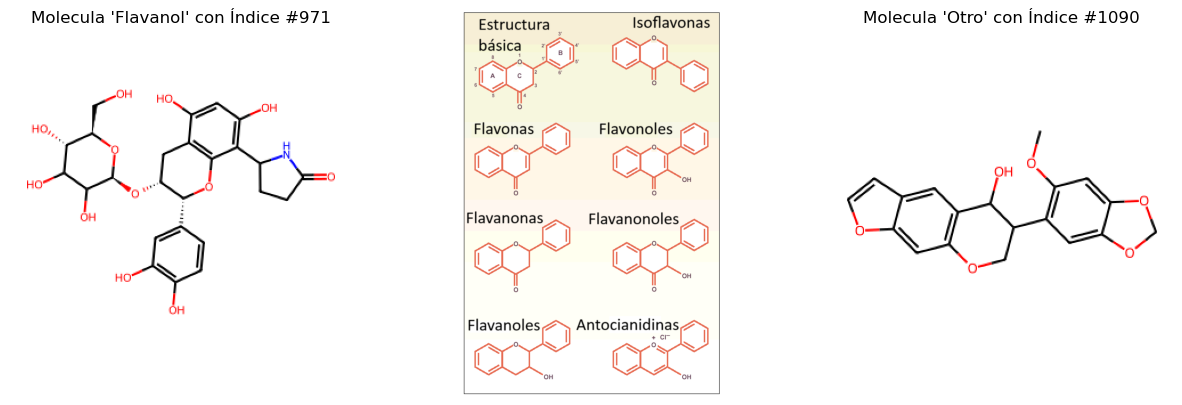

In [42]:
#Test para visualizar moleculas clasificadas

#Molecula Flavanol
df_flavanol = df[df['Tipo_flavonoide'] == 'Flavanol']
indice_molecula_flavanol = random.choice(df_flavanol.index) #Obtener índice random
# Obtener el SMILES de la molécula en el índice dado
smiles_molecula_flavanol = df.loc[indice_molecula_flavanol, 'SMILES']
plot_molecula(smiles_molecula_flavanol)
#Molecula "Otro"
df_otro = df[df['Tipo_flavonoide'] == 'Otro']
indice_molecula_otro = random.choice(df_otro.index) #Obtener índice random
# Obtener el SMILES de la molécula en el índice dado
smiles_molecula_otro = df.loc[indice_molecula_otro, 'SMILES']
plot_molecula(smiles_molecula_otro)

# Llena los valores NaN en la columna 'Estructura_flavanol' con False
df['Estructura_flavanol'] = df['Estructura_flavanol'].fillna(False)
df['Estructura_flavanol'] = df['Estructura_flavanol'].astype(bool)

#Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Ajusta el tamaño de la figura
# Eliminar los ejes de todas las imágenes
for ax in axs:
    ax.axis('off')
#Subplot 1 = "Flavanol"
axs[0].set_title(f"Molecula 'Flavanol' con Índice #{indice_molecula_flavanol}")  # Título para la imagen 1
imagen_molecula_flavanol = plot_molecula(smiles_molecula_flavanol)
axs[0].imshow(imagen_molecula_flavanol)
#Subplot 2 = "Estructuras flavonoides"
imagen = Image.open(ruta_imagen)
axs[1].imshow(imagen)
# Subplot 3 : "Otro"
axs[2].set_title(f"Molecula 'Otro' con Índice #{indice_molecula_otro}")  # Título para la imagen 3
imagen_molecula_otro = plot_molecula(smiles_molecula_otro)
axs[2].imshow(imagen_molecula_otro)
# Mostrar el gráfico
plt.show()

Ver moleculas sin clasificar

In [43]:
# Filtrar las filas donde 'Tipo_flavonoide' está vacío
indices_tipo_flavonoide_vacio = df[df['Tipo_flavonoide'] == ''].index

# Verificar los índices obtenidos
print(f"Existen {len(indices_tipo_flavonoide_vacio)} Moleculas sin clasificar")

Existen 0 Moleculas sin clasificar


# Asi quedó clasificada nuestra base de datos:

Text(0.5, 1.0, 'Distribución de Tipos de Flavonoides')

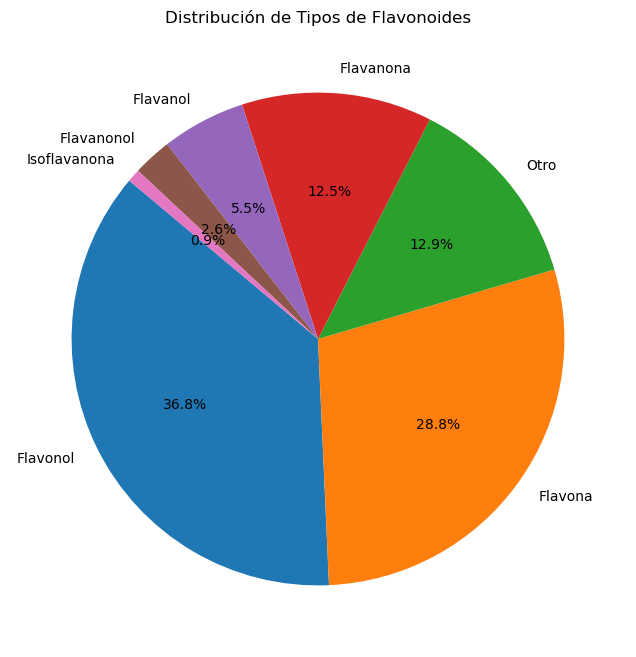

In [44]:
frequencias = df['Tipo_flavonoide'].value_counts()
# Plot
plt.figure(figsize=(8, 8))
plt.pie(frequencias, labels=frequencias.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Tipos de Flavonoides')

# Comprobar Errores

In [45]:
import itertools
condiciones = [
    'Estructura_isoflavanona',
    'Estructura_flavona',
    'Estructura_flavonol',
    'Estructura_flavanona',
    'Estructura_flavanonol',
    'Estructura_flavanol'
]

# Generar todas las combinaciones de dos estructuras
combinaciones_dos = list(itertools.combinations(condiciones, 2))
# Contar las moléculas que cumplen con cada combinación de dos condiciones
for combinacion in combinaciones_dos:
    condicion_combinada = df[list(combinacion)].all(axis=1)
    moléculas_cumplen = condicion_combinada.sum()
    print(f"Combinación {', '.join(combinacion)}: {moléculas_cumplen}")

Combinación Estructura_isoflavanona, Estructura_flavona: 0
Combinación Estructura_isoflavanona, Estructura_flavonol: 0
Combinación Estructura_isoflavanona, Estructura_flavanona: 0
Combinación Estructura_isoflavanona, Estructura_flavanonol: 0
Combinación Estructura_isoflavanona, Estructura_flavanol: 0
Combinación Estructura_flavona, Estructura_flavonol: 563
Combinación Estructura_flavona, Estructura_flavanona: 0
Combinación Estructura_flavona, Estructura_flavanonol: 0
Combinación Estructura_flavona, Estructura_flavanol: 0
Combinación Estructura_flavonol, Estructura_flavanona: 0
Combinación Estructura_flavonol, Estructura_flavanonol: 0
Combinación Estructura_flavonol, Estructura_flavanol: 0
Combinación Estructura_flavanona, Estructura_flavanonol: 39
Combinación Estructura_flavanona, Estructura_flavanol: 0
Combinación Estructura_flavanonol, Estructura_flavanol: 0


In [48]:
# Crear una máscara booleana para identificar filas con valores nulos en 'deltag'
mask = df['deltag'].isnull()
# Aplicar la máscara al DataFrame para obtener las filas deseadas
filas_con_nulos = df[mask]

# Obtener las filas con valores nulos en 'deltag' y mostrar solo las columnas especificadas
columnas_a_mostrar = ['ChEBI ID', 'ChEBI Name', 'deltag']
print(df[mask][columnas_a_mostrar])

# Calcular la cantidad de moléculas sin valor 'deltag' y mostrar el resultado
cantidad_filas_con_nulos = len(df[mask])
print(f"La cantidad de moléculas sin 'deltag' es: {cantidad_filas_con_nulos}")

# Eliminar las filas con valores nulos en 'deltag' del DataFrame original
df = df.dropna(subset=['deltag'])
print(f"Se eliminaron : {cantidad_filas_con_nulos} moleculas")

Empty DataFrame
Columns: [ChEBI ID, ChEBI Name, deltag]
Index: []
La cantidad de moléculas sin 'deltag' es: 0
Se eliminaron : 0 moleculas


#### Eliminamos columnas que ya no nos son de interes

In [50]:
df.columns


Index(['ChEBI ID', 'ChEBI Name', 'SMILES', 'deltag', 'SID', 'CID',
       'N°Carbonos', 'N°Oxigenos', 'N°S', 'N°N', 'N°Anillos', 'N°Aromaticos',
       'Estructura_isoflavona', 'Estructura_isoflavanona', 'Tipo_flavonoide',
       'Estructura_flavona', 'Estructura_flavonol', 'Estructura_flavanona',
       'Estructura_flavanonol', 'Estructura_flavanol'],
      dtype='object')

In [51]:
df = df.drop(columns=['Estructura_isoflavona', 'Estructura_isoflavanona', 'Estructura_flavona', 'Estructura_flavonol', 'Estructura_flavanona', 'Estructura_flavanonol','Estructura_flavanol'])

## Ver molecula aleatoria de la base de datos:
###### (CTRL + ENTER para actualizar molecula)

Índice aleatorio: 210
SMILES de la molécula:
ChEBI ID                                                      168189
ChEBI Name                                                Puddumin A
SMILES             O1C(C(O)C(O)C(O)C1OC2=CC=3OC(CC(=O)C3C(OC)=C2)...
deltag                                                          -9.1
SID                                                         85367380
CID                                                         13871818
N°Carbonos                                                        22
N°Oxigenos                                                        10
N°S                                                                0
N°N                                                                0
N°Anillos                                                          4
N°Aromaticos                                                       2
Tipo_flavonoide                                            Flavanona
Name: 210, dtype: object


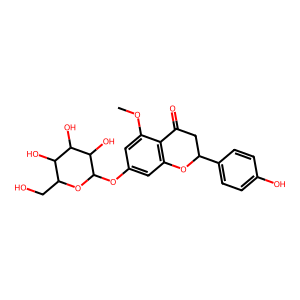

In [52]:
indice_aleatorio = df.sample().index[0]
# Obtener el SMILES correspondiente al índice aleatorio
smiles_molecula = df.loc[indice_aleatorio, 'SMILES']
# Mostrar el índice aleatorio y el SMILES de la molécula
print("Índice aleatorio:", indice_aleatorio)
print("SMILES de la molécula:")
print(df.loc[indice_aleatorio])
mostrar_molecula(smiles_molecula)  

# Análisis

In [53]:
from sklearn.preprocessing import MinMaxScaler
# Inicializa el MinMaxScaler
scaler = MinMaxScaler()
# Aplica el scaler a la columna 'deltag'
df['deltag_scaled'] = scaler.fit_transform(df['deltag'].values.reshape(-1, 1))
print(df[['ChEBI ID', 'deltag', 'deltag_scaled']].sample(n=10))

      ChEBI ID  deltag  deltag_scaled
1363    185236    -8.3       0.771930
714     187390    -8.9       0.666667
673     169356    -8.6       0.719298
1109    168515   -10.0       0.473684
452     191740   -10.3       0.421053
576     191132   -10.5       0.385965
850     175931    -7.4       0.929825
669     176209    -9.0       0.649123
1208    193367    -9.4       0.578947
318     193321    -9.1       0.631579


<Figure size 1000x600 with 0 Axes>

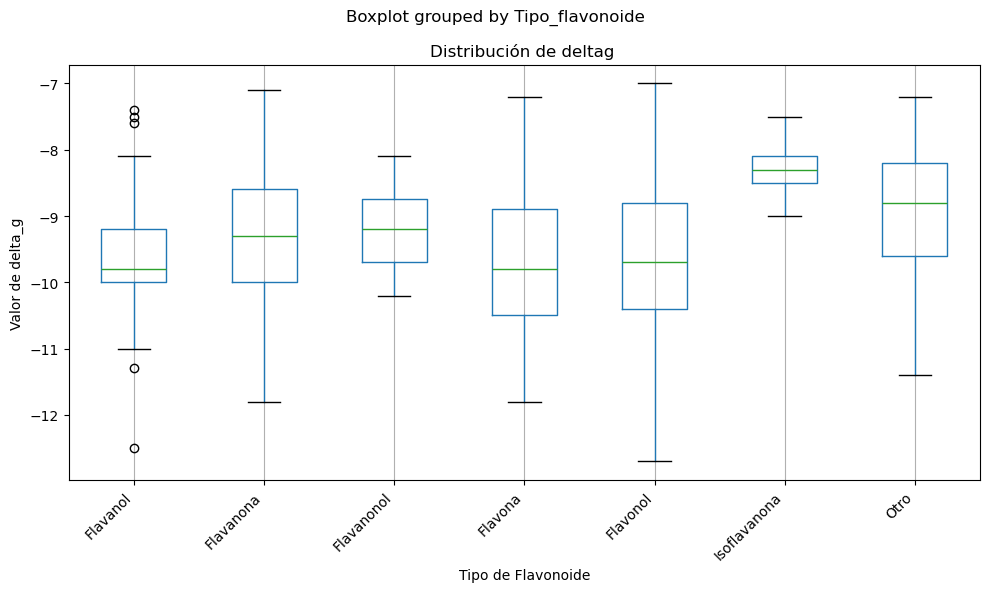

In [54]:
plt.figure(figsize=(10, 6))
df.boxplot(column='deltag', by='Tipo_flavonoide', figsize=(10, 6))
plt.xlabel('Tipo de Flavonoide')
plt.ylabel('Valor de delta_g')
plt.title('Distribución de deltag ')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

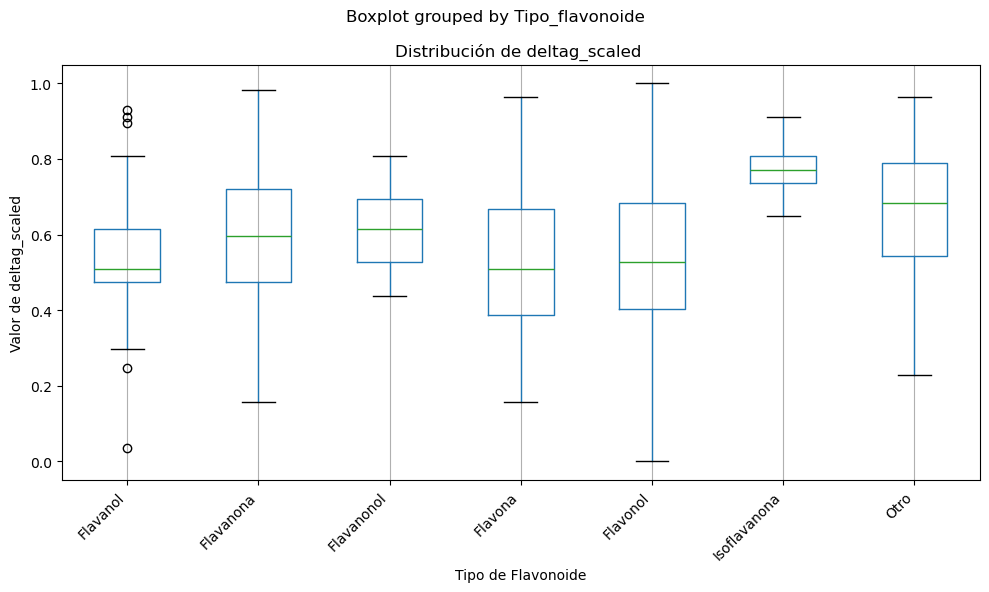

In [55]:
plt.figure(figsize=(10, 6))
df.boxplot(column='deltag_scaled', by='Tipo_flavonoide', figsize=(10, 6))
plt.xlabel('Tipo de Flavonoide')
plt.ylabel('Valor de deltag_scaled')
plt.title('Distribución de deltag_scaled ')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

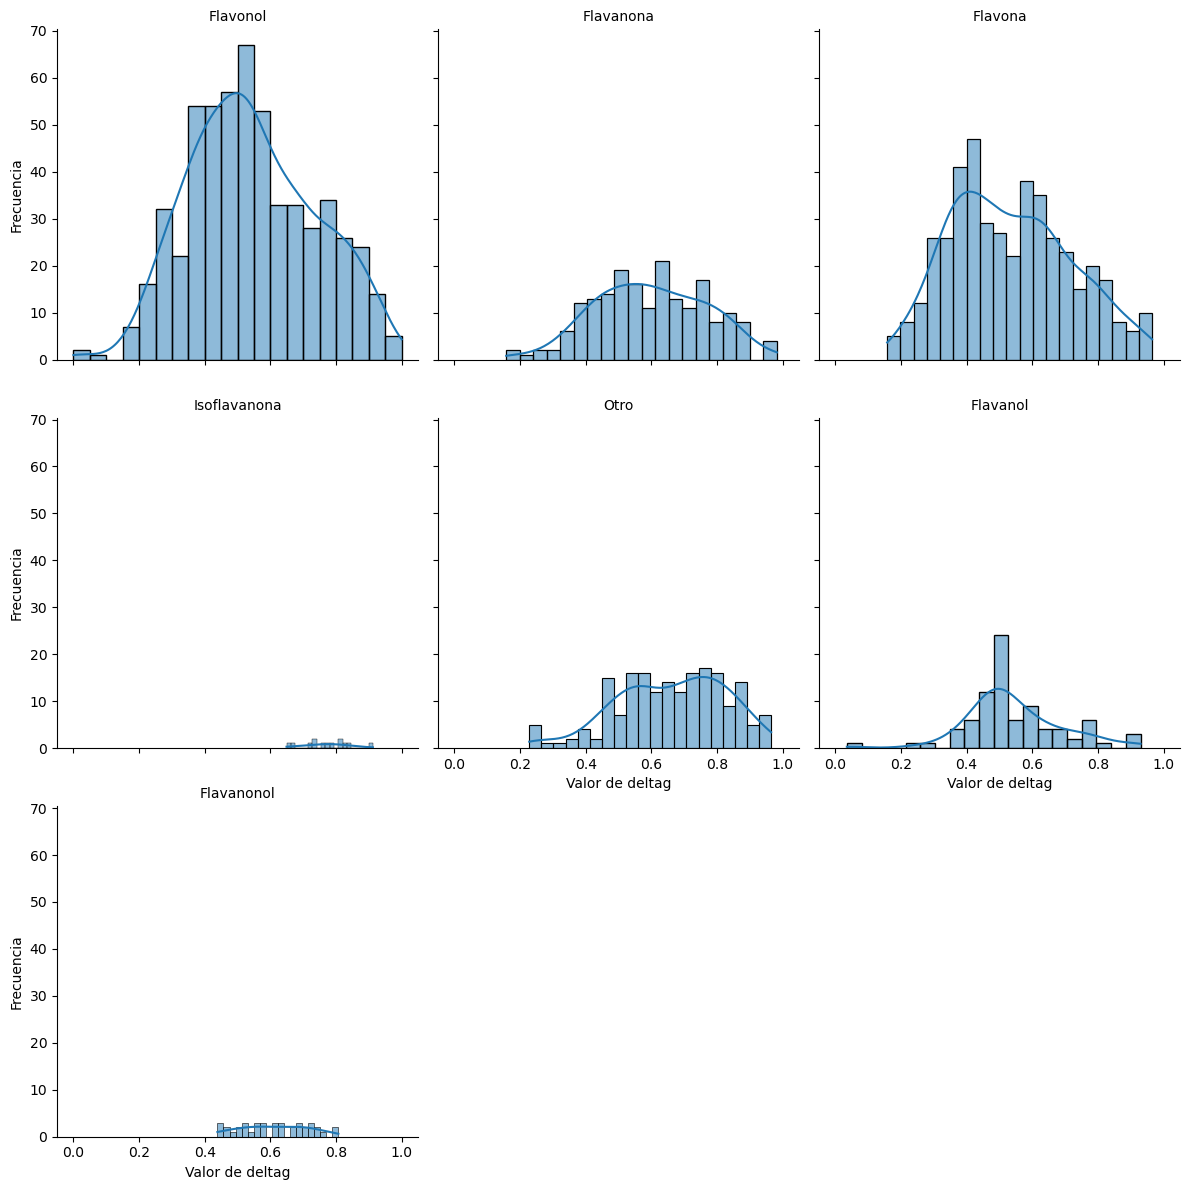

In [56]:
import seaborn as sns

# Crear una instancia de FacetGrid para cada grupo en 'Tipo_flavonoide'
g = sns.FacetGrid(df, col='Tipo_flavonoide', col_wrap=3, height=4)
g.map_dataframe(sns.histplot, x='deltag_scaled', kde=True, bins=20)

# Agregar títulos y etiquetas a cada gráfico
g.set_axis_labels('Valor de deltag', 'Frecuencia')
g.set_titles('{col_name}')
g.set_xlabels('Valor de deltag')

# Ajustar el espaciado entre subgráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


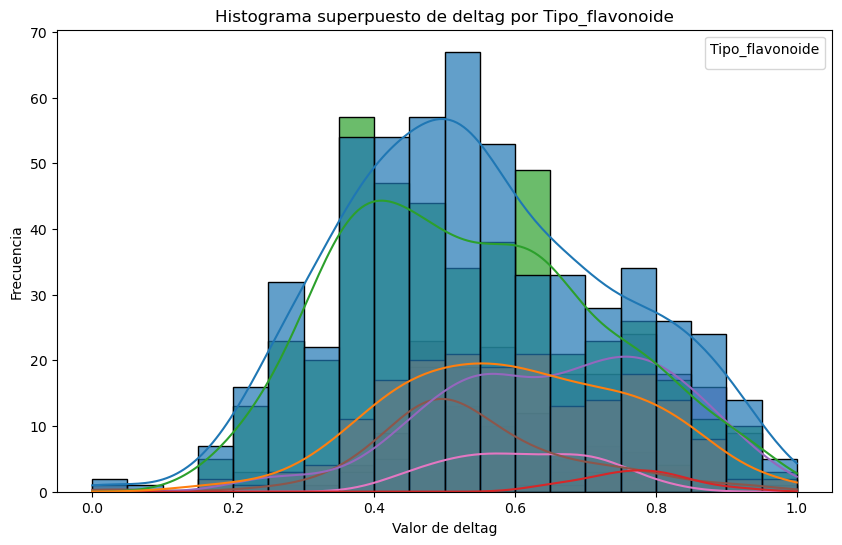

In [57]:
# Crear un histograma superpuesto para todos los grupos en 'Tipo_flavonoide'
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='deltag_scaled', hue='Tipo_flavonoide', kde=True, bins=20, alpha=0.7)
plt.title('Histograma superpuesto de deltag por Tipo_flavonoide')
plt.xlabel('Valor de deltag')
plt.ylabel('Frecuencia')
plt.legend(title='Tipo_flavonoide')
plt.show()

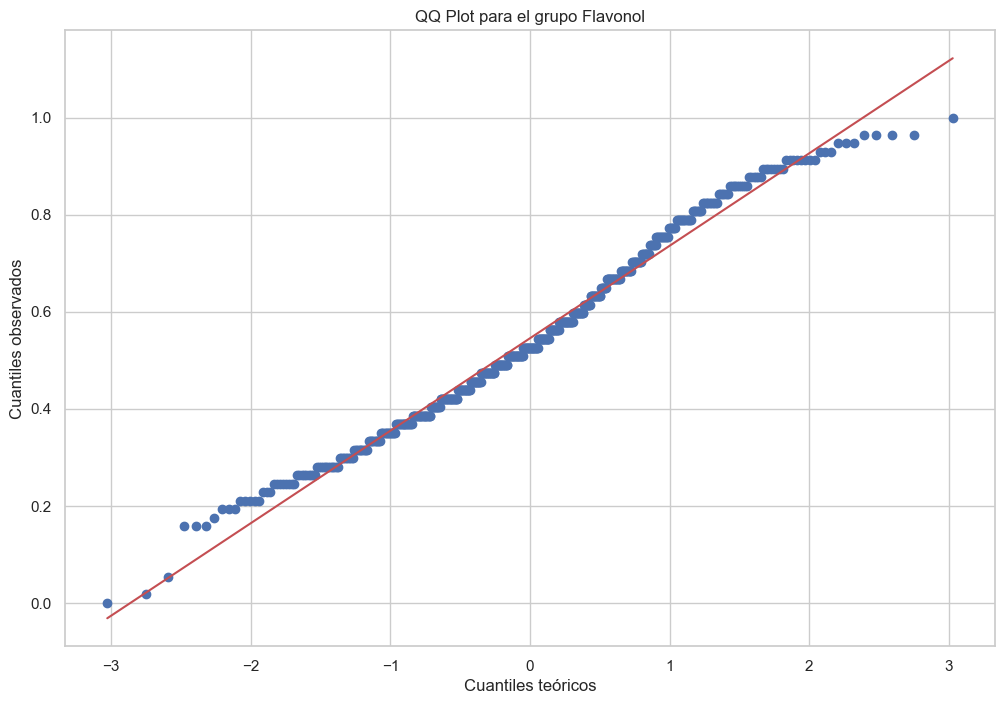

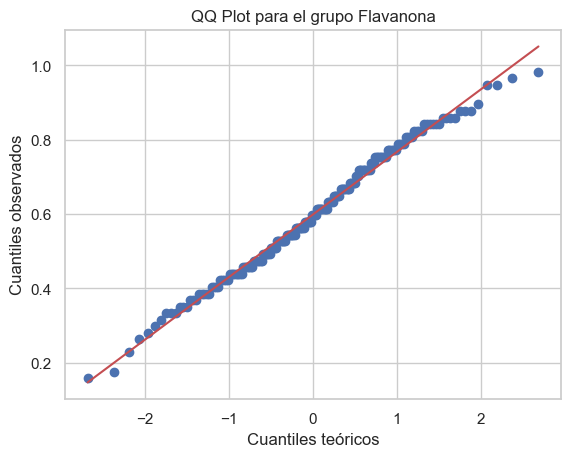

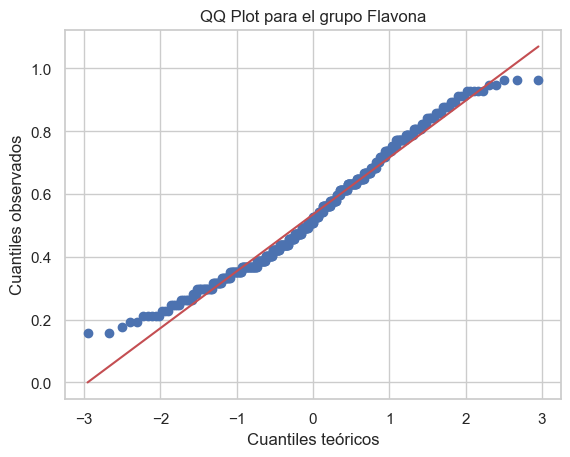

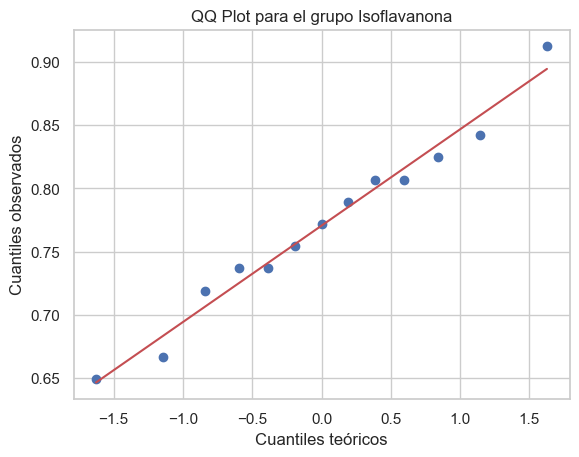

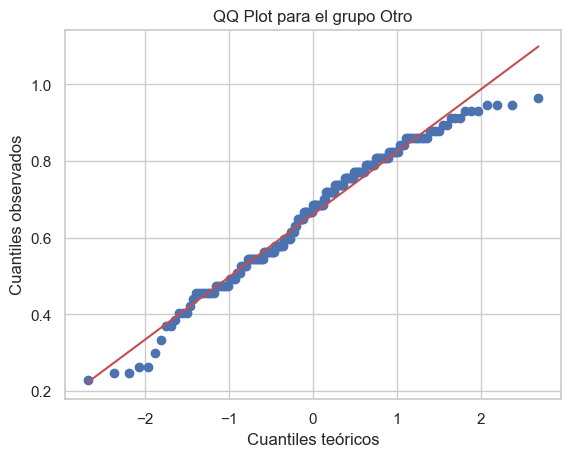

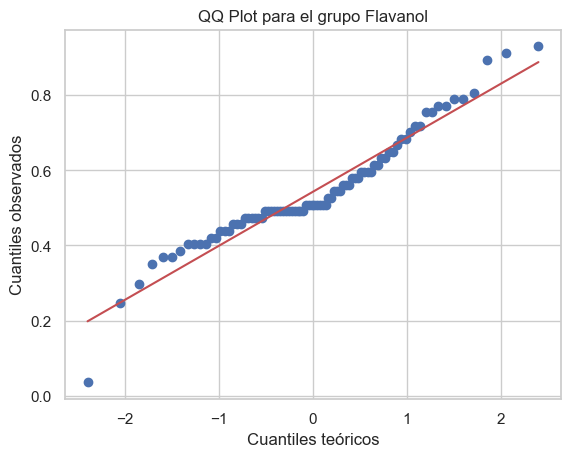

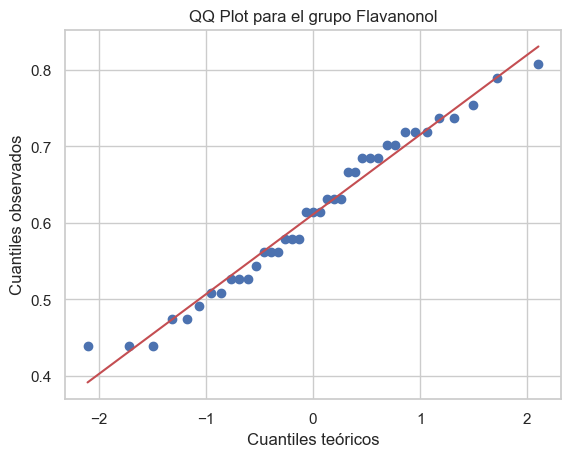

In [58]:
from scipy import stats

# Supongamos que df es tu dataframe que contiene los datos
# Vamos a generar QQ Plots para cada grupo de flavonoides en 'Tipo_flavonoide'

# Obtener la lista de grupos únicos en 'Tipo_flavonoide'
grupos_flavonoides = df['Tipo_flavonoide'].unique()

# Configurar el estilo y tamaño de las figuras
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Iterar sobre cada grupo y generar un QQ Plot para cada uno
for grupo in grupos_flavonoides:
    # Filtrar los datos para el grupo actual
    datos_grupo = df[df['Tipo_flavonoide'] == grupo]['deltag_scaled']
    # Generar el QQ Plot para el grupo actual
    stats.probplot(datos_grupo, dist="norm", plot=plt)
    plt.title(f'QQ Plot para el grupo {grupo}')
    plt.xlabel('Cuantiles teóricos')
    plt.ylabel('Cuantiles observados')
    
    # Mostrar cada QQ Plot en una nueva figura
    plt.show()

In [59]:
from scipy.stats import levene

# Supongamos que df es tu DataFrame con los datos
# Agrupa los datos por el tipo de flavonoide y selecciona la columna deltag_scaled
grouped_data = df.groupby('Tipo_flavonoide')['deltag_scaled']

# Crea una lista para almacenar los datos de cada grupo
data_groups = [group.values for name, group in grouped_data]

# Aplica el test de Levene a los datos
statistic, p_value = levene(*data_groups)

# Imprime los resultados del test
print("Estadístico de Levene:", statistic)
print("Valor p:", p_value)

# Comprueba la significancia del test
alpha = 0.05
if p_value > alpha:
    print("No se rechaza la hipótesis nula. Las varianzas son homogéneas.")
else:
    print("Se rechaza la hipótesis nula. Las varianzas no son homogéneas.")


Estadístico de Levene: 7.527780631096714
Valor p: 5.712176024100029e-08
Se rechaza la hipótesis nula. Las varianzas no son homogéneas.


In [60]:
from scipy.stats import bartlett

# Suponiendo que tienes un DataFrame df y quieres comparar las varianzas de la columna 'deltag_scaled' entre grupos de 'Tipo_flavonoide'
grouped_data = [group['deltag_scaled'].dropna() for name, group in df.groupby('Tipo_flavonoide')]
bartlett_result = bartlett(*grouped_data)

# Mostrar el resultado del test de Bartlett
print("Estadístico de Bartlett:", bartlett_result.statistic)
print("Valor p de Bartlett:", bartlett_result.pvalue)

# Interpretar el resultado
if bartlett_result.pvalue > 0.05:
    print("No se rechaza la hipótesis nula. Las varianzas son homogéneas.")
else:
    print("Se rechaza la hipótesis nula. Las varianzas no son homogéneas.")

Estadístico de Bartlett: 44.16272614248258
Valor p de Bartlett: 6.862671414699569e-08
Se rechaza la hipótesis nula. Las varianzas no son homogéneas.


In [61]:
from scipy.stats import f_oneway

# Suponiendo que tienes un DataFrame df y quieres comparar la columna 'deltag_scaled' entre grupos de 'Tipo_flavonoide'
grouped_data = [group['deltag_scaled'].dropna() for name, group in df.groupby('Tipo_flavonoide')]
f_statistic, p_value = f_oneway(*grouped_data)

# Mostrar el resultado del ANOVA de Welch
print("Estadístico F de Welch:", f_statistic)
print("Valor p de ANOVA de Welch:", p_value)

# Interpretar el resultado
if p_value > 0.05:
    print("No se rechaza la hipótesis nula. No hay diferencias significativas entre grupos.")
else:
    print("Se rechaza la hipótesis nula. Hay diferencias significativas entre grupos.")

Estadístico F de Welch: 17.111504251787675
Valor p de ANOVA de Welch: 3.242908880938804e-19
Se rechaza la hipótesis nula. Hay diferencias significativas entre grupos.


_______________________________________________________________________________________________________________________________

In [ ]:
plt.figure(figsize=(10, 6))
df.boxplot(column='deltag', by='N°Carbonos', figsize=(10, 6))
plt.xlabel('N° de Carbonos')
plt.ylabel('Valor de delta_g')
plt.title('Distribución de delta_g por N° Carbonos')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
df.boxplot(column='deltag', by='N°Oxigenos', figsize=(10, 6))
plt.xlabel('N° de Oxigenos')
plt.ylabel('Valor de delta_g')
plt.title('Distribución de delta_g por N° O')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
df.boxplot(column='deltag', by='N°Anillos', figsize=(10, 6))
plt.xlabel('Numero de anillos')
plt.ylabel('Valor de delta_g')
plt.title('Distribución de delta_g por N° de Anillos')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

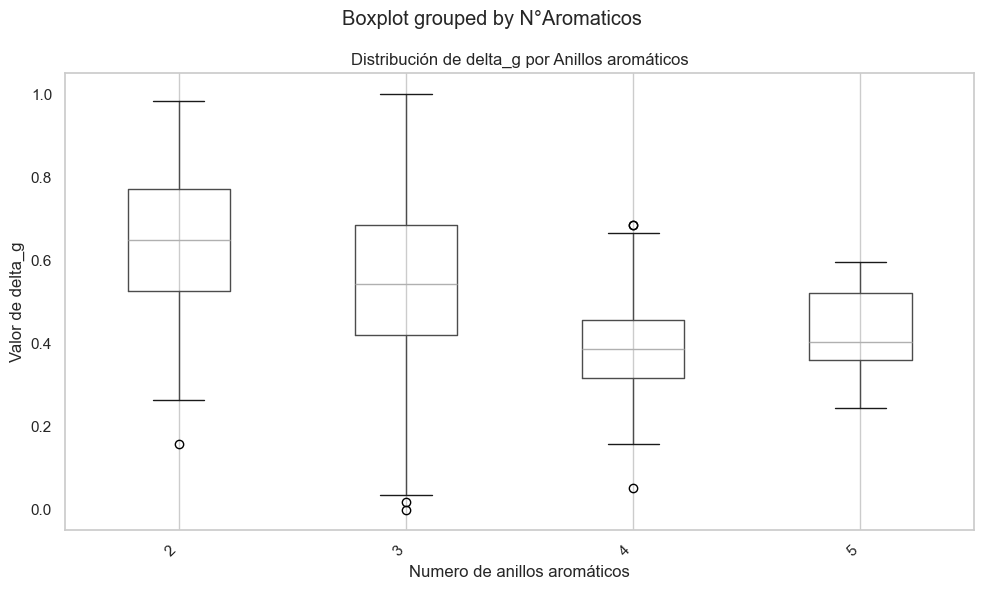

In [63]:
plt.figure(figsize=(10, 6))
df.boxplot(column='deltag_scaled', by='N°Aromaticos', figsize=(10, 6))
plt.xlabel('Numero de anillos aromáticos')
plt.ylabel('Valor de delta_g')
plt.title('Distribución de delta_g por Anillos aromáticos')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()